In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.activation1 = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride= 1, padding= 2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activation2 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride= 1, padding= 2)
    
    def forward(self,x):
        residual  = torch.clone(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv1(x)
        x = self.conv2(self.activation2(self.bn2(x)))
        residual = residual.unsqueeze(0)
        residual = nn.functional.interpolate(residual, size = [x.shape[1], x.shape[2], x.shape[3]])
        residual = residual.squeeze(0)
        x += residual
        return x
     
class ModelSubDep(nn.Module):

    def __init__(self):
        super(ModelSubDep, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 5, out_channels = 32, kernel_size= 3, stride= 1, padding= 2)
        self.resblock1 = ResidualBlock(32,32,5)
        self.resblock2 = ResidualBlock(32,64,5)
        self.resblock3 = ResidualBlock(64,128,5)
        self.avgpool = nn.AdaptiveAvgPool2d((15,15))
        self.linear1 = nn.Linear(15*15*128, 1024)
        self.drop1 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(1024, 512)
        self.drop2 = nn.Dropout(0.2)
        self.linear3 = nn.Linear(512, 2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.avgpool(x)
        F = nn.Flatten()
        x = F(x)
        x = self.linear1(x)
        x = self.drop1(x)
        x = self.linear2(x)
        x = self.drop2(x)
        x = self.linear3(x)
        x = self.softmax(x)
        return x

In [5]:
import scipy
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import StratifiedKFold as skf

class Dataset(Dataset):
    def __init__(self, data, info):
        #data loading
        self.x = data
        self.y = info
        self.n_samples = data.shape[0]


    def __getitem__(self,index):
        t1 = self.x[index]
        t2 = self.y[index]
        t1 = torch.tensor(t1)
        t1 = t1.permute((2,0,1))
        t2 = torch.tensor(t2)
        return (t1,t2)
    
    def __len__(self):
        return self.n_samples
    
data = scipy.io.loadmat('/home/desktop/Desktop/22104412_Docs/EEG-COGMusic/Baseline/datasets/s02_datasets_Zscore_clipped.mat')

In [6]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'coh', 'pli', 'psd', 'labels_kfold', 'valence', 'arousal', 'multiclass', 'EEGNet'])

In [7]:
x_c=data['coh']
x_p = data['pli']
x_d = data['psd']
labels_skf = data['labels_kfold']
labels = data['arousal']

In [8]:
# dt = data['data']
# labels_skf = data['labels_kfold']
# labels = data['valence']

In [9]:
labels_skf.shape

(40, 2)

In [10]:
x_n = np.zeros((40,75,32,32,5))
for trial in range(x_n.shape[0]):
    for sample in range(x_n.shape[1]):
        x_n[trial,sample,:,:,0] = x_c[trial,sample,:,:,0]+np.transpose(x_c[trial,sample,:,:,0])
        x_n[trial,sample,:,:,1] = x_c[trial,sample,:,:,1]+np.transpose(x_c[trial,sample,:,:,1])
        x_n[trial,sample,:,:,2] = x_c[trial,sample,:,:,2]+np.transpose(x_c[trial,sample,:,:,2])
        x_n[trial,sample,:,:,3] = x_c[trial,sample,:,:,3]+np.transpose(x_c[trial,sample,:,:,3])
        x_n[trial,sample,:,:,4] = x_c[trial,sample,:,:,4]+np.transpose(x_c[trial,sample,:,:,4])
    print(f'Completed trial {trial}')

for trial in range(x_n.shape[0]):
    for sample in range(x_n.shape[1]):
        for i in range(32):
            x_n[trial,sample,i,i,:] = x_d[trial,sample,i,:]
    print(f'Completed trial {trial}')

Completed trial 0
Completed trial 1
Completed trial 2
Completed trial 3
Completed trial 4
Completed trial 5
Completed trial 6
Completed trial 7
Completed trial 8
Completed trial 9
Completed trial 10
Completed trial 11
Completed trial 12
Completed trial 13
Completed trial 14
Completed trial 15
Completed trial 16
Completed trial 17
Completed trial 18
Completed trial 19
Completed trial 20
Completed trial 21
Completed trial 22
Completed trial 23
Completed trial 24
Completed trial 25
Completed trial 26
Completed trial 27
Completed trial 28
Completed trial 29
Completed trial 30
Completed trial 31
Completed trial 32
Completed trial 33
Completed trial 34
Completed trial 35
Completed trial 36
Completed trial 37
Completed trial 38
Completed trial 39
Completed trial 0
Completed trial 1
Completed trial 2
Completed trial 3
Completed trial 4
Completed trial 5
Completed trial 6
Completed trial 7
Completed trial 8
Completed trial 9
Completed trial 10
Completed trial 11
Completed trial 12
Completed tri

In [11]:
v = labels_skf[:,0]

In [13]:
indices = np.where((v>5.5)|(v<4.5))[0]

In [14]:
indices.shape

(31,)

In [16]:
dt = x_n[indices]
labels = labels[indices]
trainLoss={}
valLoss = {}
trainAcc = {}
valAcc = {}

In [17]:
dt.shape

(31, 75, 32, 32, 5)

In [18]:
labels.shape

(31, 75, 2)

In [19]:
labels_skf.shape

(40, 2)

In [20]:
l_skf = np.zeros([40,1])
l_skf[np.where(labels_skf[:,1]>5)[0]] = 1

In [21]:
l_skf = l_skf[indices]

In [22]:
l_skf.shape

(31, 1)

In [23]:
kf = skf(n_splits = 10)
l = []
ind = []
for k,(train_index,test_index) in enumerate(kf.split(dt,l_skf)):
    labelsTr, labelsV = labels[train_index], labels[test_index]   
    l.append({'train': labelsTr,
            'valid': labelsV})
    ind.append([train_index,test_index])

/home/desktop/anaconda3/envs/cogmusic/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


In [24]:
counts = []
for fold in range(len(l)):
    count_hv_t = 0
    count_lv_t = 0
    count_hv_v = 0
    count_lv_v = 0
    l_fold = l[fold]
    for label in l_fold['train']:
        if (label == [0.,1.]).all():
            count_hv_t += 1
        else:
            count_lv_t +=1
    for label in l_fold['valid']:
        if (label == [0.,1.]).all():
            count_hv_v += 1
        else:
            count_lv_v +=1
    counts.append([count_hv_t,count_lv_t,count_hv_v,count_lv_v])    
    print(f'Fold {fold} completed')




Fold 0 completed
Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed
Fold 6 completed
Fold 7 completed
Fold 8 completed
Fold 9 completed


In [25]:
df = pd.DataFrame(data=counts, columns= ['hv_t','lv_t','hv_v','lv_v'])

In [26]:
print(df)

   hv_t  lv_t  hv_v  lv_v
0    19     8     3     1
1    19     9     3     0
2    20     8     2     1
3    20     8     2     1
4    20     8     2     1
5    20     8     2     1
6    20     8     2     1
7    20     8     2     1
8    20     8     2     1
9    20     8     2     1


<Axes: >

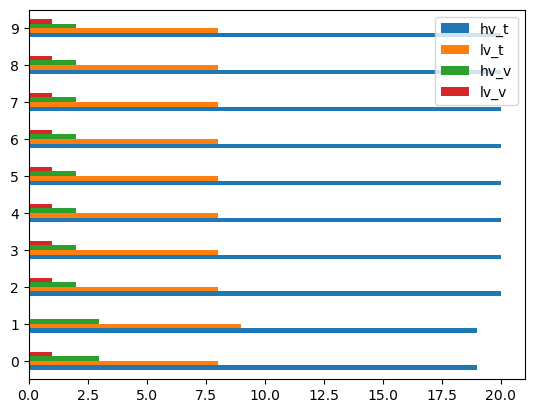

In [27]:
df.plot.barh()

In [28]:
l_skf

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [29]:
dt.shape

(31, 75, 32, 32, 5)

In [30]:
labels.shape

(31, 75, 2)

In [31]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class FocalLoss(nn.Module):
#     def __init__(self, alpha, gamma):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets):
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-ce_loss)
#         weights = [self.alpha[t] for t in targets]
#         weights = torch.tensor(np.array(weights))
#         weights = weights.to('cuda')
#         loss = (weights* (1 - pt) ** self.gamma * ce_loss).mean()
#         return loss

In [32]:
from focal_loss.focal_loss import FocalLoss

In [33]:
kf = skf(n_splits = 10)
log_pred_dict = {}
for k,(train_index,test_index) in enumerate(kf.split(dt, l_skf)):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f'Fold {k+1} running')
    dataTr, dataV = np.concatenate(dt[train_index],0), np.concatenate(dt[test_index],0)
    labelsTr, labelsV = np.concatenate(labels[train_index],0), np.concatenate(labels[test_index],0)
    # y_train = np.argmax(labelsTr, axis=1)
    # dataTr = dataTr.reshape(dataTr.shape[0],-1)
    # dataTr,labelsTr = RandomOverSampler(sampling_strategy='minority').fit_resample(dataTr,y_train)
    # dataTr = dataTr.reshape(-1,32,32,5)
    # labelsTr = to_categorical(labelsTr)
    tL = []
    vL = []
    tAV = []
    vAV = []
    y_train = np.argmax(labelsTr, axis=1)
    class_counts = np.bincount(y_train)
    num_classes = len(class_counts)
    total_samples = len(y_train)

    class_weights = []
    for count in class_counts:
        weight = 1 / (count / total_samples)
        class_weights.append(weight)
    
    weights = torch.tensor(np.array(class_weights))
    weights = weights.to(device)
    # testAC = []
    model = ModelSubDep()
    model = model.to(device)
     # Define your weights as a tensor
    criterion1 = nn.CrossEntropyLoss(weight=weights)
    optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum= 0.9)
    trainDS = Dataset(dataTr, labelsTr)
    trainDL = DataLoader(dataset = trainDS, batch_size = 100, shuffle = True)
 
    valDS = Dataset(dataV, labelsV)
    valDL = DataLoader(dataset = valDS, batch_size = 100, shuffle = True)
    
    testDS = Dataset(dataV, labelsV)
    testDL = DataLoader(dataset = testDS, batch_size = 100)
    num_epochs = 50
    batchsize = 100
    l2_lambda = 0.001
    for epoch in range(num_epochs):
        trainAccuracy = 0
        totalLoss = 0
        with tqdm(trainDL, unit='batch') as tepoch:
            model.train()
            for imagest,lab in tepoch:
                imagest = imagest.to(device)
                lab = lab.to(device)
                optimizer_ft.zero_grad()
                outputs = (model(imagest.float()))
                _,predindex = torch.max(outputs, dim = 1)
                _,labindex = torch.max(lab, dim = 1)
                loss = criterion1(outputs,lab.float())
                l2_reg = 0.0
                for param in model.parameters():
                    l2_reg += torch.norm(param, p=2) # L2 norm of the parameter
                loss += l2_lambda * l2_reg
                loss.backward()
                optimizer_ft.step()
                totalLoss+=loss.item()
                acc = (predindex==labindex).sum().item()
                trainAccuracy += acc/(lab.shape[0]*len(trainDL))
                tepoch.set_postfix(loss=loss.item(),totalLoss =totalLoss/len(trainDL), TrainAccuracy= 100.*trainAccuracy)      
            model.eval()
            with torch.no_grad():
                with tqdm(valDL, unit='batch') as tepoch:
                    total = 0
                    valAccuracy = 0
                    val_loss = 0
                    for imagesv,labv in tepoch:
                        imagesv = imagesv.to(device)
                        labelsv = labv.to(device)
                        outval = (model(imagesv.float()))
                        _,predindexval = torch.max(outval,dim = 1)
                        _,labvalindex = torch.max(labelsv,dim = 1)
                        acc = (predindexval == labvalindex).sum().item()
                        valAccuracy +=acc/(labv.shape[0]*len(valDL))
                        lossv = criterion1(outval,labelsv.float())
                        val_loss+= lossv.item()
                        tepoch.set_postfix(lossv=lossv.item(),valLoss =val_loss/len(valDL), ValAccuracy= 100.*valAccuracy)
        print('Epoch [{}], Loss_t: {:.4f},Loss_v: {:.4f}, train_acc:{:.4f}, val_acc:{:.4f}'.format(epoch, totalLoss/len(trainDL), val_loss/len(valDL),
                                                                                                   100.*trainAccuracy,
                                                                                                   100.*valAccuracy))
        tL.append(totalLoss/len(trainDL))
        vL.append(val_loss/len(valDL))
        tAV.append(100.*trainAccuracy)
        vAV.append( 100.*valAccuracy)
    trainLoss[str(k)] = tL
    valLoss[str(k)] = vL
    trainAcc[str(k)] = tAV
    valAcc[str(k)] = vAV
    model.eval()
    pt = []
    lt = []
    with torch.no_grad():
        with tqdm(testDL, unit='batch') as tepochtst:
            for imagestst,labt in tepochtst:
                imagestst = imagestst.to(device)
                labelst = labt.to(device)
                outt = (model(imagestst.float()))
                _,predt = torch.max(outt,dim=1)
                _,labti = torch.max(labelst,dim =1)
                pt.append(predt)
                lt.append(labti)
    log_pred_dict[str(k)] = {'trails': test_index,
                             'predicted': pt,
                             'ground truth': lt}
tL = np.array(list(trainLoss.values()))
vL = np.array(list(valLoss.values()))
tAV = np.array(list(trainAcc.values()))
vAV = np.array(list(valAcc.values()))

/home/desktop/anaconda3/envs/cogmusic/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Fold 1 running


100%|██████████| 3/3 [00:00<00:00, 31.75batch/s, ValAccuracy=25, lossv=1.32, valLoss=1.33]


Epoch [0], Loss_t: 1.5015,Loss_v: 1.3293, train_acc:36.0000, val_acc:25.0000


100%|██████████| 3/3 [00:00<00:00, 32.76batch/s, ValAccuracy=34.3, lossv=1.3, valLoss=1.33]


Epoch [1], Loss_t: 1.4921,Loss_v: 1.3289, train_acc:52.5238, val_acc:34.3333


100%|██████████| 3/3 [00:00<00:00, 31.96batch/s, ValAccuracy=41, lossv=1.35, valLoss=1.33]


Epoch [2], Loss_t: 1.4967,Loss_v: 1.3285, train_acc:53.2857, val_acc:41.0000


100%|██████████| 3/3 [00:00<00:00, 31.65batch/s, ValAccuracy=29, lossv=1.34, valLoss=1.33]


Epoch [3], Loss_t: 1.5017,Loss_v: 1.3284, train_acc:47.5714, val_acc:29.0000


100%|██████████| 3/3 [00:00<00:00, 31.63batch/s, ValAccuracy=25, lossv=1.34, valLoss=1.33]


Epoch [4], Loss_t: 1.5006,Loss_v: 1.3297, train_acc:41.7619, val_acc:25.0000


100%|██████████| 3/3 [00:00<00:00, 32.72batch/s, ValAccuracy=35.7, lossv=1.3, valLoss=1.33]


Epoch [5], Loss_t: 1.5006,Loss_v: 1.3277, train_acc:40.5714, val_acc:35.6667


100%|██████████| 3/3 [00:00<00:00, 33.27batch/s, ValAccuracy=50, lossv=1.3, valLoss=1.33]


Epoch [6], Loss_t: 1.4880,Loss_v: 1.3261, train_acc:51.9524, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 31.98batch/s, ValAccuracy=25.3, lossv=1.37, valLoss=1.33]


Epoch [7], Loss_t: 1.4959,Loss_v: 1.3288, train_acc:54.4286, val_acc:25.3333


100%|██████████| 3/3 [00:00<00:00, 32.61batch/s, ValAccuracy=36.3, lossv=1.34, valLoss=1.33]


Epoch [8], Loss_t: 1.4953,Loss_v: 1.3264, train_acc:41.2857, val_acc:36.3333


100%|██████████| 3/3 [00:00<00:00, 32.86batch/s, ValAccuracy=37.7, lossv=1.27, valLoss=1.33]


Epoch [9], Loss_t: 1.4923,Loss_v: 1.3255, train_acc:49.2381, val_acc:37.6667


100%|██████████| 3/3 [00:00<00:00, 31.94batch/s, ValAccuracy=50, lossv=1.31, valLoss=1.32]


Epoch [10], Loss_t: 1.4939,Loss_v: 1.3247, train_acc:47.4762, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 31.44batch/s, ValAccuracy=52, lossv=1.27, valLoss=1.32]


Epoch [11], Loss_t: 1.4925,Loss_v: 1.3243, train_acc:51.0000, val_acc:52.0000


100%|██████████| 3/3 [00:00<00:00, 31.51batch/s, ValAccuracy=49.3, lossv=1.36, valLoss=1.32]


Epoch [12], Loss_t: 1.4934,Loss_v: 1.3240, train_acc:50.0000, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 31.81batch/s, ValAccuracy=25.3, lossv=1.37, valLoss=1.33]


Epoch [13], Loss_t: 1.5017,Loss_v: 1.3285, train_acc:57.9048, val_acc:25.3333


100%|██████████| 3/3 [00:00<00:00, 33.39batch/s, ValAccuracy=64.7, lossv=1.39, valLoss=1.32]


Epoch [14], Loss_t: 1.4929,Loss_v: 1.3212, train_acc:34.7143, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 31.14batch/s, ValAccuracy=63, lossv=1.35, valLoss=1.32]


Epoch [15], Loss_t: 1.4913,Loss_v: 1.3216, train_acc:66.5238, val_acc:63.0000


100%|██████████| 3/3 [00:00<00:00, 33.15batch/s, ValAccuracy=59.7, lossv=1.3, valLoss=1.32]


Epoch [16], Loss_t: 1.4899,Loss_v: 1.3220, train_acc:43.8095, val_acc:59.6667


100%|██████████| 3/3 [00:00<00:00, 31.49batch/s, ValAccuracy=54.3, lossv=1.31, valLoss=1.32]


Epoch [17], Loss_t: 1.4898,Loss_v: 1.3223, train_acc:62.4762, val_acc:54.3333


100%|██████████| 3/3 [00:00<00:00, 31.58batch/s, ValAccuracy=48.7, lossv=1.41, valLoss=1.32]


Epoch [18], Loss_t: 1.4918,Loss_v: 1.3233, train_acc:62.4286, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 31.25batch/s, ValAccuracy=52, lossv=1.3, valLoss=1.32]


Epoch [19], Loss_t: 1.4940,Loss_v: 1.3221, train_acc:42.4762, val_acc:52.0000


100%|██████████| 3/3 [00:00<00:00, 31.18batch/s, ValAccuracy=39, lossv=1.41, valLoss=1.32]


Epoch [20], Loss_t: 1.4916,Loss_v: 1.3238, train_acc:64.1905, val_acc:39.0000


100%|██████████| 3/3 [00:00<00:00, 31.85batch/s, ValAccuracy=56, lossv=1.35, valLoss=1.32]


Epoch [21], Loss_t: 1.4874,Loss_v: 1.3212, train_acc:35.0952, val_acc:56.0000


100%|██████████| 3/3 [00:00<00:00, 32.53batch/s, ValAccuracy=53.7, lossv=1.23, valLoss=1.32]


Epoch [22], Loss_t: 1.4804,Loss_v: 1.3210, train_acc:64.7143, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 32.07batch/s, ValAccuracy=57.3, lossv=1.32, valLoss=1.32]


Epoch [23], Loss_t: 1.4825,Loss_v: 1.3204, train_acc:52.8571, val_acc:57.3333


100%|██████████| 3/3 [00:00<00:00, 32.43batch/s, ValAccuracy=59.3, lossv=1.33, valLoss=1.32]


Epoch [24], Loss_t: 1.5023,Loss_v: 1.3203, train_acc:62.5238, val_acc:59.3333


100%|██████████| 3/3 [00:00<00:00, 31.68batch/s, ValAccuracy=43.3, lossv=1.28, valLoss=1.32]


Epoch [25], Loss_t: 1.4880,Loss_v: 1.3212, train_acc:37.7143, val_acc:43.3333


100%|██████████| 3/3 [00:00<00:00, 31.06batch/s, ValAccuracy=66, lossv=1.29, valLoss=1.32]


Epoch [26], Loss_t: 1.4868,Loss_v: 1.3175, train_acc:53.5714, val_acc:66.0000


100%|██████████| 3/3 [00:00<00:00, 31.19batch/s, ValAccuracy=44, lossv=1.37, valLoss=1.32]


Epoch [27], Loss_t: 1.4891,Loss_v: 1.3207, train_acc:64.6667, val_acc:44.0000


100%|██████████| 3/3 [00:00<00:00, 30.63batch/s, ValAccuracy=48.7, lossv=1.24, valLoss=1.32]


Epoch [28], Loss_t: 1.4825,Loss_v: 1.3197, train_acc:51.0476, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 31.55batch/s, ValAccuracy=61.3, lossv=1.31, valLoss=1.32]


Epoch [29], Loss_t: 1.4841,Loss_v: 1.3176, train_acc:62.1429, val_acc:61.3333


100%|██████████| 3/3 [00:00<00:00, 31.47batch/s, ValAccuracy=62, lossv=1.36, valLoss=1.32]


Epoch [30], Loss_t: 1.4762,Loss_v: 1.3171, train_acc:48.3333, val_acc:62.0000


100%|██████████| 3/3 [00:00<00:00, 31.44batch/s, ValAccuracy=67.7, lossv=1.33, valLoss=1.32]


Epoch [31], Loss_t: 1.4829,Loss_v: 1.3151, train_acc:66.8571, val_acc:67.6667


100%|██████████| 3/3 [00:00<00:00, 31.87batch/s, ValAccuracy=46.7, lossv=1.38, valLoss=1.32]


Epoch [32], Loss_t: 1.4777,Loss_v: 1.3182, train_acc:56.6190, val_acc:46.6667


100%|██████████| 3/3 [00:00<00:00, 33.13batch/s, ValAccuracy=63.7, lossv=1.39, valLoss=1.31]


Epoch [33], Loss_t: 1.4833,Loss_v: 1.3149, train_acc:56.1905, val_acc:63.6667


100%|██████████| 3/3 [00:00<00:00, 31.26batch/s, ValAccuracy=55, lossv=1.3, valLoss=1.32]


Epoch [34], Loss_t: 1.4789,Loss_v: 1.3167, train_acc:62.7619, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 31.65batch/s, ValAccuracy=59, lossv=1.33, valLoss=1.32]


Epoch [35], Loss_t: 1.4817,Loss_v: 1.3160, train_acc:57.4762, val_acc:59.0000


100%|██████████| 3/3 [00:00<00:00, 31.06batch/s, ValAccuracy=44.3, lossv=1.34, valLoss=1.32]


Epoch [36], Loss_t: 1.4787,Loss_v: 1.3189, train_acc:56.6190, val_acc:44.3333


100%|██████████| 3/3 [00:00<00:00, 31.07batch/s, ValAccuracy=60, lossv=1.46, valLoss=1.32]


Epoch [37], Loss_t: 1.4798,Loss_v: 1.3156, train_acc:55.2857, val_acc:60.0000


100%|██████████| 3/3 [00:00<00:00, 31.48batch/s, ValAccuracy=60, lossv=1.28, valLoss=1.31]


Epoch [38], Loss_t: 1.4792,Loss_v: 1.3148, train_acc:60.5238, val_acc:60.0000


100%|██████████| 3/3 [00:00<00:00, 31.15batch/s, ValAccuracy=66.3, lossv=1.41, valLoss=1.31]


Epoch [39], Loss_t: 1.4784,Loss_v: 1.3125, train_acc:62.0952, val_acc:66.3333


100%|██████████| 3/3 [00:00<00:00, 32.03batch/s, ValAccuracy=52.7, lossv=1.31, valLoss=1.31]


Epoch [40], Loss_t: 1.4816,Loss_v: 1.3148, train_acc:53.1905, val_acc:52.6667


100%|██████████| 3/3 [00:00<00:00, 32.10batch/s, ValAccuracy=63, lossv=1.23, valLoss=1.31]


Epoch [41], Loss_t: 1.4863,Loss_v: 1.3129, train_acc:62.7619, val_acc:63.0000


100%|██████████| 3/3 [00:00<00:00, 31.11batch/s, ValAccuracy=55.3, lossv=1.31, valLoss=1.31]


Epoch [42], Loss_t: 1.4760,Loss_v: 1.3144, train_acc:48.1429, val_acc:55.3333


100%|██████████| 3/3 [00:00<00:00, 31.37batch/s, ValAccuracy=50.3, lossv=1.28, valLoss=1.31]


Epoch [43], Loss_t: 1.4804,Loss_v: 1.3146, train_acc:61.9048, val_acc:50.3333


100%|██████████| 3/3 [00:00<00:00, 31.54batch/s, ValAccuracy=53.7, lossv=1.32, valLoss=1.31]


Epoch [44], Loss_t: 1.4742,Loss_v: 1.3138, train_acc:63.9524, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 30.04batch/s, ValAccuracy=59.7, lossv=1.37, valLoss=1.31]


Epoch [45], Loss_t: 1.4754,Loss_v: 1.3126, train_acc:58.4762, val_acc:59.6667


100%|██████████| 3/3 [00:00<00:00, 31.68batch/s, ValAccuracy=58.7, lossv=1.27, valLoss=1.31]


Epoch [46], Loss_t: 1.4795,Loss_v: 1.3130, train_acc:63.1429, val_acc:58.6667


100%|██████████| 3/3 [00:00<00:00, 30.54batch/s, ValAccuracy=61.7, lossv=1.4, valLoss=1.31]


Epoch [47], Loss_t: 1.4816,Loss_v: 1.3122, train_acc:53.0476, val_acc:61.6667


100%|██████████| 3/3 [00:00<00:00, 30.44batch/s, ValAccuracy=54.7, lossv=1.3, valLoss=1.31]


Epoch [48], Loss_t: 1.4703,Loss_v: 1.3127, train_acc:58.3333, val_acc:54.6667


100%|██████████| 3/3 [00:00<00:00, 32.75batch/s, ValAccuracy=59.3, lossv=1.36, valLoss=1.31]


Epoch [49], Loss_t: 1.4783,Loss_v: 1.3105, train_acc:54.1429, val_acc:59.3333


100%|██████████| 3/3 [00:00<00:00, 48.40batch/s]


Fold 2 running


100%|██████████| 3/3 [00:00<00:00, 41.52batch/s, ValAccuracy=26, lossv=1.03, valLoss=1.03]


Epoch [0], Loss_t: 1.4976,Loss_v: 1.0269, train_acc:45.1905, val_acc:26.0000


100%|██████████| 3/3 [00:00<00:00, 41.99batch/s, ValAccuracy=55.3, lossv=1.02, valLoss=1.02]


Epoch [1], Loss_t: 1.4961,Loss_v: 1.0215, train_acc:57.2857, val_acc:55.3333


100%|██████████| 3/3 [00:00<00:00, 39.51batch/s, ValAccuracy=91.3, lossv=1.01, valLoss=1.01]


Epoch [2], Loss_t: 1.5009,Loss_v: 1.0060, train_acc:38.5238, val_acc:91.3333


100%|██████████| 3/3 [00:00<00:00, 39.99batch/s, ValAccuracy=85.3, lossv=1.01, valLoss=1.01]


Epoch [3], Loss_t: 1.4959,Loss_v: 1.0084, train_acc:58.3810, val_acc:85.3333


100%|██████████| 3/3 [00:00<00:00, 42.02batch/s, ValAccuracy=19.3, lossv=1.03, valLoss=1.03]


Epoch [4], Loss_t: 1.4959,Loss_v: 1.0301, train_acc:41.5238, val_acc:19.3333


100%|██████████| 3/3 [00:00<00:00, 41.28batch/s, ValAccuracy=1, lossv=1.04, valLoss=1.04]


Epoch [5], Loss_t: 1.4959,Loss_v: 1.0424, train_acc:53.3333, val_acc:1.0000


100%|██████████| 3/3 [00:00<00:00, 40.60batch/s, ValAccuracy=65.7, lossv=1.02, valLoss=1.02]


Epoch [6], Loss_t: 1.4977,Loss_v: 1.0176, train_acc:54.7619, val_acc:65.6667


100%|██████████| 3/3 [00:00<00:00, 41.16batch/s, ValAccuracy=2, lossv=1.04, valLoss=1.04]


Epoch [7], Loss_t: 1.4945,Loss_v: 1.0445, train_acc:51.4286, val_acc:2.0000


100%|██████████| 3/3 [00:00<00:00, 40.55batch/s, ValAccuracy=84.7, lossv=1.01, valLoss=1]


Epoch [8], Loss_t: 1.4974,Loss_v: 1.0045, train_acc:41.2857, val_acc:84.6667


100%|██████████| 3/3 [00:00<00:00, 40.22batch/s, ValAccuracy=60, lossv=1.02, valLoss=1.02]


Epoch [9], Loss_t: 1.4940,Loss_v: 1.0210, train_acc:56.8571, val_acc:60.0000


100%|██████████| 3/3 [00:00<00:00, 39.59batch/s, ValAccuracy=66.3, lossv=1.02, valLoss=1.01]


Epoch [10], Loss_t: 1.4956,Loss_v: 1.0136, train_acc:41.4286, val_acc:66.3333


100%|██████████| 3/3 [00:00<00:00, 41.17batch/s, ValAccuracy=33.3, lossv=1.03, valLoss=1.03]


Epoch [11], Loss_t: 1.4921,Loss_v: 1.0303, train_acc:61.8095, val_acc:33.3333


100%|██████████| 3/3 [00:00<00:00, 40.69batch/s, ValAccuracy=15.7, lossv=1.03, valLoss=1.04]


Epoch [12], Loss_t: 1.4955,Loss_v: 1.0370, train_acc:40.3333, val_acc:15.6667


100%|██████████| 3/3 [00:00<00:00, 40.25batch/s, ValAccuracy=49, lossv=1.02, valLoss=1.02]


Epoch [13], Loss_t: 1.4931,Loss_v: 1.0237, train_acc:58.4286, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 40.74batch/s, ValAccuracy=33, lossv=1.03, valLoss=1.03]


Epoch [14], Loss_t: 1.4929,Loss_v: 1.0300, train_acc:46.0476, val_acc:33.0000


100%|██████████| 3/3 [00:00<00:00, 39.11batch/s, ValAccuracy=30.3, lossv=1.03, valLoss=1.03]


Epoch [15], Loss_t: 1.4925,Loss_v: 1.0314, train_acc:58.2381, val_acc:30.3333


100%|██████████| 3/3 [00:00<00:00, 39.87batch/s, ValAccuracy=79, lossv=1.01, valLoss=1]


Epoch [16], Loss_t: 1.4924,Loss_v: 1.0021, train_acc:46.0476, val_acc:79.0000


100%|██████████| 3/3 [00:00<00:00, 41.29batch/s, ValAccuracy=65, lossv=1.02, valLoss=1.02]


Epoch [17], Loss_t: 1.4917,Loss_v: 1.0167, train_acc:47.8095, val_acc:65.0000


100%|██████████| 3/3 [00:00<00:00, 38.93batch/s, ValAccuracy=47.3, lossv=1.02, valLoss=1.02]


Epoch [18], Loss_t: 1.4913,Loss_v: 1.0241, train_acc:60.1429, val_acc:47.3333


100%|██████████| 3/3 [00:00<00:00, 40.45batch/s, ValAccuracy=43, lossv=1.02, valLoss=1.03]


Epoch [19], Loss_t: 1.4888,Loss_v: 1.0258, train_acc:51.4762, val_acc:43.0000


100%|██████████| 3/3 [00:00<00:00, 41.14batch/s, ValAccuracy=63, lossv=1.02, valLoss=1.02]


Epoch [20], Loss_t: 1.4909,Loss_v: 1.0195, train_acc:46.5238, val_acc:63.0000


100%|██████████| 3/3 [00:00<00:00, 39.72batch/s, ValAccuracy=71.3, lossv=1.01, valLoss=1.01]


Epoch [21], Loss_t: 1.4890,Loss_v: 1.0106, train_acc:62.3810, val_acc:71.3333


100%|██████████| 3/3 [00:00<00:00, 40.85batch/s, ValAccuracy=58.7, lossv=1.03, valLoss=1.02]


Epoch [22], Loss_t: 1.4872,Loss_v: 1.0228, train_acc:49.9524, val_acc:58.6667


100%|██████████| 3/3 [00:00<00:00, 39.94batch/s, ValAccuracy=75.3, lossv=1.01, valLoss=1.01]


Epoch [23], Loss_t: 1.4900,Loss_v: 1.0061, train_acc:44.0000, val_acc:75.3333


100%|██████████| 3/3 [00:00<00:00, 40.99batch/s, ValAccuracy=51.3, lossv=1.03, valLoss=1.03]


Epoch [24], Loss_t: 1.4895,Loss_v: 1.0252, train_acc:66.5238, val_acc:51.3333


100%|██████████| 3/3 [00:00<00:00, 40.50batch/s, ValAccuracy=51, lossv=1.03, valLoss=1.03]


Epoch [25], Loss_t: 1.4907,Loss_v: 1.0261, train_acc:38.0000, val_acc:51.0000


100%|██████████| 3/3 [00:00<00:00, 36.73batch/s, ValAccuracy=63.3, lossv=1.02, valLoss=1.02]


Epoch [26], Loss_t: 1.4890,Loss_v: 1.0182, train_acc:61.7143, val_acc:63.3333


100%|██████████| 3/3 [00:00<00:00, 42.46batch/s, ValAccuracy=72, lossv=1.01, valLoss=1.01]


Epoch [27], Loss_t: 1.4859,Loss_v: 1.0129, train_acc:50.2381, val_acc:72.0000


100%|██████████| 3/3 [00:00<00:00, 41.57batch/s, ValAccuracy=60.3, lossv=1.02, valLoss=1.02]


Epoch [28], Loss_t: 1.4865,Loss_v: 1.0211, train_acc:61.1905, val_acc:60.3333


100%|██████████| 3/3 [00:00<00:00, 39.40batch/s, ValAccuracy=79, lossv=0.993, valLoss=1]


Epoch [29], Loss_t: 1.4875,Loss_v: 1.0005, train_acc:46.6667, val_acc:79.0000


100%|██████████| 3/3 [00:00<00:00, 39.65batch/s, ValAccuracy=67.3, lossv=1.01, valLoss=1.01]


Epoch [30], Loss_t: 1.4869,Loss_v: 1.0129, train_acc:53.8571, val_acc:67.3333


100%|██████████| 3/3 [00:00<00:00, 39.59batch/s, ValAccuracy=65, lossv=1.01, valLoss=1.01]


Epoch [31], Loss_t: 1.4851,Loss_v: 1.0150, train_acc:60.2381, val_acc:65.0000


100%|██████████| 3/3 [00:00<00:00, 40.14batch/s, ValAccuracy=67, lossv=1.02, valLoss=1.01]


Epoch [32], Loss_t: 1.4833,Loss_v: 1.0117, train_acc:57.5238, val_acc:67.0000


100%|██████████| 3/3 [00:00<00:00, 40.74batch/s, ValAccuracy=71, lossv=1.02, valLoss=1.01]


Epoch [33], Loss_t: 1.4847,Loss_v: 1.0116, train_acc:56.0476, val_acc:71.0000


100%|██████████| 3/3 [00:00<00:00, 40.89batch/s, ValAccuracy=81.7, lossv=0.993, valLoss=0.991]


Epoch [34], Loss_t: 1.4856,Loss_v: 0.9913, train_acc:51.9524, val_acc:81.6667


100%|██████████| 3/3 [00:00<00:00, 41.98batch/s, ValAccuracy=13, lossv=1.05, valLoss=1.06]


Epoch [35], Loss_t: 1.4840,Loss_v: 1.0587, train_acc:60.8095, val_acc:13.0000


100%|██████████| 3/3 [00:00<00:00, 42.50batch/s, ValAccuracy=65.7, lossv=1.01, valLoss=1.02]


Epoch [36], Loss_t: 1.4849,Loss_v: 1.0165, train_acc:50.9048, val_acc:65.6667


100%|██████████| 3/3 [00:00<00:00, 42.29batch/s, ValAccuracy=50.7, lossv=1.03, valLoss=1.03]


Epoch [37], Loss_t: 1.4821,Loss_v: 1.0263, train_acc:56.7619, val_acc:50.6667


100%|██████████| 3/3 [00:00<00:00, 40.91batch/s, ValAccuracy=79, lossv=0.998, valLoss=0.988]


Epoch [38], Loss_t: 1.4813,Loss_v: 0.9882, train_acc:58.1905, val_acc:79.0000


100%|██████████| 3/3 [00:00<00:00, 40.73batch/s, ValAccuracy=57.7, lossv=1.02, valLoss=1.02]


Epoch [39], Loss_t: 1.4854,Loss_v: 1.0242, train_acc:51.1905, val_acc:57.6667


100%|██████████| 3/3 [00:00<00:00, 41.18batch/s, ValAccuracy=76, lossv=0.989, valLoss=0.996]


Epoch [40], Loss_t: 1.4789,Loss_v: 0.9957, train_acc:61.6667, val_acc:76.0000


100%|██████████| 3/3 [00:00<00:00, 41.47batch/s, ValAccuracy=76.7, lossv=0.992, valLoss=0.992]


Epoch [41], Loss_t: 1.4807,Loss_v: 0.9920, train_acc:49.9048, val_acc:76.6667


100%|██████████| 3/3 [00:00<00:00, 40.78batch/s, ValAccuracy=46.7, lossv=1.04, valLoss=1.03]


Epoch [42], Loss_t: 1.4806,Loss_v: 1.0328, train_acc:64.8571, val_acc:46.6667


100%|██████████| 3/3 [00:00<00:00, 42.29batch/s, ValAccuracy=62, lossv=1.02, valLoss=1.02]


Epoch [43], Loss_t: 1.4798,Loss_v: 1.0207, train_acc:53.5238, val_acc:62.0000


100%|██████████| 3/3 [00:00<00:00, 40.35batch/s, ValAccuracy=80.7, lossv=0.985, valLoss=0.981]


Epoch [44], Loss_t: 1.4784,Loss_v: 0.9815, train_acc:54.0476, val_acc:80.6667


100%|██████████| 3/3 [00:00<00:00, 40.16batch/s, ValAccuracy=50, lossv=1.03, valLoss=1.03]


Epoch [45], Loss_t: 1.4793,Loss_v: 1.0291, train_acc:60.3333, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 41.26batch/s, ValAccuracy=84.3, lossv=0.96, valLoss=0.977]


Epoch [46], Loss_t: 1.4787,Loss_v: 0.9770, train_acc:60.6667, val_acc:84.3333


100%|██████████| 3/3 [00:00<00:00, 39.52batch/s, ValAccuracy=56.3, lossv=1.03, valLoss=1.03]


Epoch [47], Loss_t: 1.4752,Loss_v: 1.0269, train_acc:60.9048, val_acc:56.3333


100%|██████████| 3/3 [00:00<00:00, 41.31batch/s, ValAccuracy=64, lossv=1, valLoss=1.02]


Epoch [48], Loss_t: 1.4762,Loss_v: 1.0150, train_acc:59.7143, val_acc:64.0000


100%|██████████| 3/3 [00:00<00:00, 41.12batch/s, ValAccuracy=58.3, lossv=1.02, valLoss=1.03]


Epoch [49], Loss_t: 1.4767,Loss_v: 1.0251, train_acc:53.7143, val_acc:58.3333


100%|██████████| 3/3 [00:00<00:00, 47.12batch/s]


Fold 3 running


100%|██████████| 3/3 [00:00<00:00, 39.42batch/s, ValAccuracy=39, lossv=1.76, valLoss=1.53]


Epoch [0], Loss_t: 1.5002,Loss_v: 1.5295, train_acc:53.5714, val_acc:39.0000


100%|██████████| 3/3 [00:00<00:00, 41.55batch/s, ValAccuracy=34, lossv=1.48, valLoss=1.46]


Epoch [1], Loss_t: 1.4995,Loss_v: 1.4567, train_acc:47.3810, val_acc:34.0000


100%|██████████| 3/3 [00:00<00:00, 42.02batch/s, ValAccuracy=33, lossv=1.44, valLoss=1.45]


Epoch [2], Loss_t: 1.4954,Loss_v: 1.4472, train_acc:38.5714, val_acc:33.0000


100%|██████████| 3/3 [00:00<00:00, 40.07batch/s, ValAccuracy=63.3, lossv=1.58, valLoss=1.49]


Epoch [3], Loss_t: 1.4969,Loss_v: 1.4930, train_acc:44.3810, val_acc:63.3333


100%|██████████| 3/3 [00:00<00:00, 41.12batch/s, ValAccuracy=32, lossv=1.38, valLoss=1.43]


Epoch [4], Loss_t: 1.4954,Loss_v: 1.4328, train_acc:66.4762, val_acc:32.0000


100%|██████████| 3/3 [00:00<00:00, 40.30batch/s, ValAccuracy=68.7, lossv=1.19, valLoss=1.4]


Epoch [5], Loss_t: 1.5007,Loss_v: 1.3964, train_acc:34.0000, val_acc:68.6667


100%|██████████| 3/3 [00:00<00:00, 37.80batch/s, ValAccuracy=33, lossv=1.43, valLoss=1.44]


Epoch [6], Loss_t: 1.4978,Loss_v: 1.4448, train_acc:60.1429, val_acc:33.0000


100%|██████████| 3/3 [00:00<00:00, 38.84batch/s, ValAccuracy=53.3, lossv=1.44, valLoss=1.45]


Epoch [7], Loss_t: 1.4933,Loss_v: 1.4543, train_acc:43.7619, val_acc:53.3333


100%|██████████| 3/3 [00:00<00:00, 40.89batch/s, ValAccuracy=33, lossv=1.42, valLoss=1.44]


Epoch [8], Loss_t: 1.4942,Loss_v: 1.4381, train_acc:57.7143, val_acc:33.0000


100%|██████████| 3/3 [00:00<00:00, 39.71batch/s, ValAccuracy=44.3, lossv=1.54, valLoss=1.48]


Epoch [9], Loss_t: 1.4958,Loss_v: 1.4774, train_acc:44.1905, val_acc:44.3333


100%|██████████| 3/3 [00:00<00:00, 39.76batch/s, ValAccuracy=63, lossv=1.45, valLoss=1.46]


Epoch [10], Loss_t: 1.4952,Loss_v: 1.4640, train_acc:43.7143, val_acc:63.0000


100%|██████████| 3/3 [00:00<00:00, 39.20batch/s, ValAccuracy=38.7, lossv=1.65, valLoss=1.5]


Epoch [11], Loss_t: 1.4926,Loss_v: 1.5015, train_acc:59.1429, val_acc:38.6667


100%|██████████| 3/3 [00:00<00:00, 38.58batch/s, ValAccuracy=36, lossv=1.39, valLoss=1.44]


Epoch [12], Loss_t: 1.4918,Loss_v: 1.4375, train_acc:49.3333, val_acc:36.0000


100%|██████████| 3/3 [00:00<00:00, 40.33batch/s, ValAccuracy=47, lossv=1.32, valLoss=1.43]


Epoch [13], Loss_t: 1.4905,Loss_v: 1.4252, train_acc:43.4286, val_acc:47.0000


100%|██████████| 3/3 [00:00<00:00, 43.17batch/s, ValAccuracy=37.7, lossv=1.37, valLoss=1.43]


Epoch [14], Loss_t: 1.4928,Loss_v: 1.4298, train_acc:61.1905, val_acc:37.6667


100%|██████████| 3/3 [00:00<00:00, 41.45batch/s, ValAccuracy=54.3, lossv=1.44, valLoss=1.46]


Epoch [15], Loss_t: 1.4902,Loss_v: 1.4567, train_acc:49.4286, val_acc:54.3333


100%|██████████| 3/3 [00:00<00:00, 40.56batch/s, ValAccuracy=44, lossv=1.61, valLoss=1.49]


Epoch [16], Loss_t: 1.4885,Loss_v: 1.4942, train_acc:50.3810, val_acc:44.0000


100%|██████████| 3/3 [00:00<00:00, 36.70batch/s, ValAccuracy=46.7, lossv=1.78, valLoss=1.54]


Epoch [17], Loss_t: 1.4889,Loss_v: 1.5396, train_acc:46.3810, val_acc:46.6667


100%|██████████| 3/3 [00:00<00:00, 39.70batch/s, ValAccuracy=38, lossv=1.63, valLoss=1.49]


Epoch [18], Loss_t: 1.4906,Loss_v: 1.4942, train_acc:62.8571, val_acc:38.0000


100%|██████████| 3/3 [00:00<00:00, 38.77batch/s, ValAccuracy=54.3, lossv=1.44, valLoss=1.46]


Epoch [19], Loss_t: 1.4869,Loss_v: 1.4600, train_acc:37.8571, val_acc:54.3333


100%|██████████| 3/3 [00:00<00:00, 41.23batch/s, ValAccuracy=43.3, lossv=1.44, valLoss=1.45]


Epoch [20], Loss_t: 1.4858,Loss_v: 1.4543, train_acc:61.7619, val_acc:43.3333


100%|██████████| 3/3 [00:00<00:00, 40.41batch/s, ValAccuracy=48.7, lossv=1.48, valLoss=1.46]


Epoch [21], Loss_t: 1.4855,Loss_v: 1.4639, train_acc:56.2857, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 41.01batch/s, ValAccuracy=40, lossv=1.42, valLoss=1.45]


Epoch [22], Loss_t: 1.4828,Loss_v: 1.4474, train_acc:49.1905, val_acc:40.0000


100%|██████████| 3/3 [00:00<00:00, 41.84batch/s, ValAccuracy=46.3, lossv=1.5, valLoss=1.47]


Epoch [23], Loss_t: 1.4860,Loss_v: 1.4715, train_acc:63.1429, val_acc:46.3333


100%|██████████| 3/3 [00:00<00:00, 40.40batch/s, ValAccuracy=43.7, lossv=1.33, valLoss=1.43]


Epoch [24], Loss_t: 1.4817,Loss_v: 1.4285, train_acc:47.0000, val_acc:43.6667


100%|██████████| 3/3 [00:00<00:00, 40.40batch/s, ValAccuracy=37.7, lossv=1.45, valLoss=1.45]


Epoch [25], Loss_t: 1.4835,Loss_v: 1.4545, train_acc:54.4762, val_acc:37.6667


100%|██████████| 3/3 [00:00<00:00, 40.75batch/s, ValAccuracy=40, lossv=1.48, valLoss=1.46]


Epoch [26], Loss_t: 1.4846,Loss_v: 1.4619, train_acc:59.4286, val_acc:40.0000


100%|██████████| 3/3 [00:00<00:00, 39.43batch/s, ValAccuracy=40.7, lossv=1.38, valLoss=1.44]


Epoch [27], Loss_t: 1.4799,Loss_v: 1.4383, train_acc:56.0476, val_acc:40.6667


100%|██████████| 3/3 [00:00<00:00, 41.23batch/s, ValAccuracy=54, lossv=1.46, valLoss=1.47]


Epoch [28], Loss_t: 1.4842,Loss_v: 1.4703, train_acc:47.5714, val_acc:54.0000


100%|██████████| 3/3 [00:00<00:00, 39.80batch/s, ValAccuracy=39, lossv=1.54, valLoss=1.47]


Epoch [29], Loss_t: 1.4807,Loss_v: 1.4749, train_acc:62.1429, val_acc:39.0000


100%|██████████| 3/3 [00:00<00:00, 40.98batch/s, ValAccuracy=40.3, lossv=1.62, valLoss=1.5]


Epoch [30], Loss_t: 1.4790,Loss_v: 1.5028, train_acc:46.9524, val_acc:40.3333


100%|██████████| 3/3 [00:00<00:00, 40.04batch/s, ValAccuracy=43, lossv=1.22, valLoss=1.4]


Epoch [31], Loss_t: 1.4829,Loss_v: 1.4033, train_acc:53.0476, val_acc:43.0000


100%|██████████| 3/3 [00:00<00:00, 40.99batch/s, ValAccuracy=46.7, lossv=1.36, valLoss=1.44]


Epoch [32], Loss_t: 1.4809,Loss_v: 1.4419, train_acc:56.0000, val_acc:46.6667


100%|██████████| 3/3 [00:00<00:00, 40.82batch/s, ValAccuracy=43.7, lossv=1.35, valLoss=1.44]


Epoch [33], Loss_t: 1.4808,Loss_v: 1.4395, train_acc:58.4286, val_acc:43.6667


100%|██████████| 3/3 [00:00<00:00, 40.45batch/s, ValAccuracy=45, lossv=1.61, valLoss=1.5]


Epoch [34], Loss_t: 1.4774,Loss_v: 1.5005, train_acc:56.0952, val_acc:45.0000


100%|██████████| 3/3 [00:00<00:00, 39.47batch/s, ValAccuracy=45.7, lossv=1.56, valLoss=1.49]


Epoch [35], Loss_t: 1.4777,Loss_v: 1.4913, train_acc:56.9524, val_acc:45.6667


100%|██████████| 3/3 [00:00<00:00, 39.75batch/s, ValAccuracy=46, lossv=1.28, valLoss=1.42]


Epoch [36], Loss_t: 1.4771,Loss_v: 1.4234, train_acc:54.5714, val_acc:46.0000


100%|██████████| 3/3 [00:00<00:00, 41.53batch/s, ValAccuracy=40, lossv=1.36, valLoss=1.44]


Epoch [37], Loss_t: 1.4704,Loss_v: 1.4364, train_acc:66.0952, val_acc:40.0000


100%|██████████| 3/3 [00:00<00:00, 39.81batch/s, ValAccuracy=49, lossv=1.6, valLoss=1.51]


Epoch [38], Loss_t: 1.4712,Loss_v: 1.5088, train_acc:51.1905, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 41.67batch/s, ValAccuracy=40, lossv=1.46, valLoss=1.46]


Epoch [39], Loss_t: 1.4732,Loss_v: 1.4618, train_acc:60.3333, val_acc:40.0000


100%|██████████| 3/3 [00:00<00:00, 41.46batch/s, ValAccuracy=43, lossv=1.48, valLoss=1.47]


Epoch [40], Loss_t: 1.4708,Loss_v: 1.4657, train_acc:60.2857, val_acc:43.0000


100%|██████████| 3/3 [00:00<00:00, 39.59batch/s, ValAccuracy=47.7, lossv=1.67, valLoss=1.53]


Epoch [41], Loss_t: 1.4669,Loss_v: 1.5273, train_acc:53.0952, val_acc:47.6667


100%|██████████| 3/3 [00:00<00:00, 38.58batch/s, ValAccuracy=38, lossv=1.48, valLoss=1.47]


Epoch [42], Loss_t: 1.4725,Loss_v: 1.4653, train_acc:62.9524, val_acc:38.0000


100%|██████████| 3/3 [00:00<00:00, 41.19batch/s, ValAccuracy=53, lossv=1.57, valLoss=1.5]


Epoch [43], Loss_t: 1.4662,Loss_v: 1.5046, train_acc:49.7143, val_acc:53.0000


100%|██████████| 3/3 [00:00<00:00, 39.75batch/s, ValAccuracy=38, lossv=1.41, valLoss=1.45]


Epoch [44], Loss_t: 1.4688,Loss_v: 1.4513, train_acc:62.3810, val_acc:38.0000


100%|██████████| 3/3 [00:00<00:00, 41.34batch/s, ValAccuracy=39, lossv=1.38, valLoss=1.45]


Epoch [45], Loss_t: 1.4676,Loss_v: 1.4538, train_acc:61.3333, val_acc:39.0000


100%|██████████| 3/3 [00:00<00:00, 41.86batch/s, ValAccuracy=45.3, lossv=1.54, valLoss=1.5]


Epoch [46], Loss_t: 1.4649,Loss_v: 1.4978, train_acc:54.8571, val_acc:45.3333


100%|██████████| 3/3 [00:00<00:00, 39.84batch/s, ValAccuracy=43.3, lossv=1.37, valLoss=1.45]


Epoch [47], Loss_t: 1.4620,Loss_v: 1.4491, train_acc:57.2857, val_acc:43.3333


100%|██████████| 3/3 [00:00<00:00, 41.12batch/s, ValAccuracy=48.7, lossv=1.4, valLoss=1.47]


Epoch [48], Loss_t: 1.4618,Loss_v: 1.4655, train_acc:58.9524, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 41.92batch/s, ValAccuracy=44, lossv=1.36, valLoss=1.45]


Epoch [49], Loss_t: 1.4625,Loss_v: 1.4465, train_acc:59.0952, val_acc:44.0000


100%|██████████| 3/3 [00:00<00:00, 48.55batch/s]


Fold 4 running


100%|██████████| 3/3 [00:00<00:00, 41.00batch/s, ValAccuracy=36.3, lossv=1.43, valLoss=1.45]


Epoch [0], Loss_t: 1.5003,Loss_v: 1.4492, train_acc:43.0952, val_acc:36.3333


100%|██████████| 3/3 [00:00<00:00, 41.72batch/s, ValAccuracy=63.3, lossv=1.5, valLoss=1.47]


Epoch [1], Loss_t: 1.4965,Loss_v: 1.4681, train_acc:44.7143, val_acc:63.3333


100%|██████████| 3/3 [00:00<00:00, 39.08batch/s, ValAccuracy=67, lossv=1.38, valLoss=1.44]


Epoch [2], Loss_t: 1.4989,Loss_v: 1.4392, train_acc:41.4286, val_acc:67.0000


100%|██████████| 3/3 [00:00<00:00, 39.59batch/s, ValAccuracy=29, lossv=1.24, valLoss=1.4]


Epoch [3], Loss_t: 1.4995,Loss_v: 1.3964, train_acc:55.8571, val_acc:29.0000


100%|██████████| 3/3 [00:00<00:00, 41.87batch/s, ValAccuracy=32, lossv=1.28, valLoss=1.41]


Epoch [4], Loss_t: 1.4981,Loss_v: 1.4099, train_acc:32.5714, val_acc:32.0000


100%|██████████| 3/3 [00:00<00:00, 41.44batch/s, ValAccuracy=65, lossv=1.51, valLoss=1.47]


Epoch [5], Loss_t: 1.4958,Loss_v: 1.4727, train_acc:63.3333, val_acc:65.0000


100%|██████████| 3/3 [00:00<00:00, 41.93batch/s, ValAccuracy=33.7, lossv=1.28, valLoss=1.41]


Epoch [6], Loss_t: 1.4961,Loss_v: 1.4114, train_acc:49.8095, val_acc:33.6667


100%|██████████| 3/3 [00:00<00:00, 41.67batch/s, ValAccuracy=34.7, lossv=1.38, valLoss=1.44]


Epoch [7], Loss_t: 1.4951,Loss_v: 1.4378, train_acc:44.3333, val_acc:34.6667


100%|██████████| 3/3 [00:00<00:00, 40.01batch/s, ValAccuracy=39.3, lossv=1.37, valLoss=1.43]


Epoch [8], Loss_t: 1.4969,Loss_v: 1.4338, train_acc:53.0952, val_acc:39.3333


100%|██████████| 3/3 [00:00<00:00, 39.83batch/s, ValAccuracy=40.7, lossv=1.42, valLoss=1.45]


Epoch [9], Loss_t: 1.4922,Loss_v: 1.4469, train_acc:43.7619, val_acc:40.6667


100%|██████████| 3/3 [00:00<00:00, 41.10batch/s, ValAccuracy=36, lossv=1.39, valLoss=1.44]


Epoch [10], Loss_t: 1.4952,Loss_v: 1.4376, train_acc:57.6667, val_acc:36.0000


100%|██████████| 3/3 [00:00<00:00, 41.57batch/s, ValAccuracy=38, lossv=1.33, valLoss=1.42]


Epoch [11], Loss_t: 1.4918,Loss_v: 1.4242, train_acc:46.4286, val_acc:38.0000


100%|██████████| 3/3 [00:00<00:00, 44.14batch/s, ValAccuracy=45.3, lossv=1.49, valLoss=1.46]


Epoch [12], Loss_t: 1.4933,Loss_v: 1.4636, train_acc:39.2857, val_acc:45.3333


100%|██████████| 3/3 [00:00<00:00, 40.76batch/s, ValAccuracy=43.7, lossv=1.55, valLoss=1.48]


Epoch [13], Loss_t: 1.4933,Loss_v: 1.4809, train_acc:59.2381, val_acc:43.6667


100%|██████████| 3/3 [00:00<00:00, 38.27batch/s, ValAccuracy=62.7, lossv=1.45, valLoss=1.46]


Epoch [14], Loss_t: 1.4921,Loss_v: 1.4574, train_acc:51.3810, val_acc:62.6667


100%|██████████| 3/3 [00:00<00:00, 41.68batch/s, ValAccuracy=40, lossv=1.58, valLoss=1.48]


Epoch [15], Loss_t: 1.4913,Loss_v: 1.4840, train_acc:61.6667, val_acc:40.0000


100%|██████████| 3/3 [00:00<00:00, 38.85batch/s, ValAccuracy=42.7, lossv=1.38, valLoss=1.44]


Epoch [16], Loss_t: 1.4892,Loss_v: 1.4380, train_acc:40.9524, val_acc:42.6667


100%|██████████| 3/3 [00:00<00:00, 39.14batch/s, ValAccuracy=52, lossv=1.26, valLoss=1.41]


Epoch [17], Loss_t: 1.4902,Loss_v: 1.4094, train_acc:49.9048, val_acc:52.0000


100%|██████████| 3/3 [00:00<00:00, 40.80batch/s, ValAccuracy=38, lossv=1.39, valLoss=1.44]


Epoch [18], Loss_t: 1.4921,Loss_v: 1.4372, train_acc:48.7619, val_acc:38.0000


100%|██████████| 3/3 [00:00<00:00, 41.84batch/s, ValAccuracy=51, lossv=1.66, valLoss=1.51]


Epoch [19], Loss_t: 1.4903,Loss_v: 1.5054, train_acc:60.9048, val_acc:51.0000


100%|██████████| 3/3 [00:00<00:00, 36.45batch/s, ValAccuracy=45.3, lossv=1.51, valLoss=1.47]


Epoch [20], Loss_t: 1.4872,Loss_v: 1.4699, train_acc:53.0952, val_acc:45.3333


100%|██████████| 3/3 [00:00<00:00, 40.53batch/s, ValAccuracy=43, lossv=1.48, valLoss=1.46]


Epoch [21], Loss_t: 1.4890,Loss_v: 1.4607, train_acc:47.0000, val_acc:43.0000


100%|██████████| 3/3 [00:00<00:00, 40.46batch/s, ValAccuracy=37.3, lossv=1.43, valLoss=1.45]


Epoch [22], Loss_t: 1.4906,Loss_v: 1.4455, train_acc:55.3333, val_acc:37.3333


100%|██████████| 3/3 [00:00<00:00, 42.49batch/s, ValAccuracy=51.7, lossv=1.26, valLoss=1.41]


Epoch [23], Loss_t: 1.4881,Loss_v: 1.4068, train_acc:50.2857, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 40.85batch/s, ValAccuracy=50, lossv=1.33, valLoss=1.42]


Epoch [24], Loss_t: 1.4862,Loss_v: 1.4230, train_acc:52.0000, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 40.44batch/s, ValAccuracy=38, lossv=1.49, valLoss=1.46]


Epoch [25], Loss_t: 1.4876,Loss_v: 1.4583, train_acc:62.7619, val_acc:38.0000


100%|██████████| 3/3 [00:00<00:00, 39.98batch/s, ValAccuracy=43.7, lossv=1.62, valLoss=1.49]


Epoch [26], Loss_t: 1.4847,Loss_v: 1.4921, train_acc:44.3810, val_acc:43.6667


100%|██████████| 3/3 [00:00<00:00, 40.09batch/s, ValAccuracy=45.3, lossv=1.53, valLoss=1.47]


Epoch [27], Loss_t: 1.4854,Loss_v: 1.4706, train_acc:58.8571, val_acc:45.3333


100%|██████████| 3/3 [00:00<00:00, 41.66batch/s, ValAccuracy=41, lossv=1.43, valLoss=1.45]


Epoch [28], Loss_t: 1.4853,Loss_v: 1.4461, train_acc:52.3810, val_acc:41.0000


100%|██████████| 3/3 [00:00<00:00, 39.67batch/s, ValAccuracy=63.3, lossv=1.36, valLoss=1.43]


Epoch [29], Loss_t: 1.4859,Loss_v: 1.4333, train_acc:46.5714, val_acc:63.3333


100%|██████████| 3/3 [00:00<00:00, 41.32batch/s, ValAccuracy=44.7, lossv=1.32, valLoss=1.42]


Epoch [30], Loss_t: 1.4854,Loss_v: 1.4156, train_acc:63.3333, val_acc:44.6667


100%|██████████| 3/3 [00:00<00:00, 42.10batch/s, ValAccuracy=53.3, lossv=1.46, valLoss=1.45]


Epoch [31], Loss_t: 1.4832,Loss_v: 1.4540, train_acc:51.4762, val_acc:53.3333


100%|██████████| 3/3 [00:00<00:00, 41.81batch/s, ValAccuracy=56.3, lossv=1.46, valLoss=1.45]


Epoch [32], Loss_t: 1.4840,Loss_v: 1.4543, train_acc:47.7619, val_acc:56.3333


100%|██████████| 3/3 [00:00<00:00, 39.98batch/s, ValAccuracy=58.3, lossv=1.67, valLoss=1.51]


Epoch [33], Loss_t: 1.4839,Loss_v: 1.5095, train_acc:54.2857, val_acc:58.3333


100%|██████████| 3/3 [00:00<00:00, 41.44batch/s, ValAccuracy=54, lossv=1.44, valLoss=1.45]


Epoch [34], Loss_t: 1.4830,Loss_v: 1.4487, train_acc:54.7619, val_acc:54.0000


100%|██████████| 3/3 [00:00<00:00, 40.07batch/s, ValAccuracy=49.7, lossv=1.59, valLoss=1.48]


Epoch [35], Loss_t: 1.4783,Loss_v: 1.4839, train_acc:59.5714, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 38.53batch/s, ValAccuracy=41, lossv=1.43, valLoss=1.44]


Epoch [36], Loss_t: 1.4815,Loss_v: 1.4392, train_acc:63.8571, val_acc:41.0000


100%|██████████| 3/3 [00:00<00:00, 41.29batch/s, ValAccuracy=56, lossv=1.65, valLoss=1.5]


Epoch [37], Loss_t: 1.4794,Loss_v: 1.5024, train_acc:43.0000, val_acc:56.0000


100%|██████████| 3/3 [00:00<00:00, 41.24batch/s, ValAccuracy=38.3, lossv=1.41, valLoss=1.43]


Epoch [38], Loss_t: 1.4806,Loss_v: 1.4344, train_acc:65.9524, val_acc:38.3333


100%|██████████| 3/3 [00:00<00:00, 39.77batch/s, ValAccuracy=57.3, lossv=1.3, valLoss=1.41]


Epoch [39], Loss_t: 1.4776,Loss_v: 1.4131, train_acc:46.3810, val_acc:57.3333


100%|██████████| 3/3 [00:00<00:00, 40.90batch/s, ValAccuracy=54.7, lossv=1.18, valLoss=1.38]


Epoch [40], Loss_t: 1.4781,Loss_v: 1.3820, train_acc:61.1905, val_acc:54.6667


100%|██████████| 3/3 [00:00<00:00, 40.14batch/s, ValAccuracy=51.7, lossv=1.4, valLoss=1.43]


Epoch [41], Loss_t: 1.4792,Loss_v: 1.4340, train_acc:53.2381, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 40.60batch/s, ValAccuracy=48.7, lossv=1.39, valLoss=1.43]


Epoch [42], Loss_t: 1.4751,Loss_v: 1.4318, train_acc:56.0952, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 40.87batch/s, ValAccuracy=51.7, lossv=1.13, valLoss=1.37]


Epoch [43], Loss_t: 1.4754,Loss_v: 1.3685, train_acc:58.1905, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 39.72batch/s, ValAccuracy=58.3, lossv=1.48, valLoss=1.46]


Epoch [44], Loss_t: 1.4781,Loss_v: 1.4632, train_acc:51.3810, val_acc:58.3333


100%|██████████| 3/3 [00:00<00:00, 40.98batch/s, ValAccuracy=36.3, lossv=1.34, valLoss=1.42]


Epoch [45], Loss_t: 1.4762,Loss_v: 1.4158, train_acc:55.5238, val_acc:36.3333


100%|██████████| 3/3 [00:00<00:00, 39.47batch/s, ValAccuracy=64, lossv=1.43, valLoss=1.45]


Epoch [46], Loss_t: 1.4727,Loss_v: 1.4489, train_acc:59.4762, val_acc:64.0000


100%|██████████| 3/3 [00:00<00:00, 39.30batch/s, ValAccuracy=55.3, lossv=1.6, valLoss=1.49]


Epoch [47], Loss_t: 1.4739,Loss_v: 1.4854, train_acc:54.0476, val_acc:55.3333


100%|██████████| 3/3 [00:00<00:00, 40.04batch/s, ValAccuracy=48.7, lossv=1.47, valLoss=1.45]


Epoch [48], Loss_t: 1.4729,Loss_v: 1.4476, train_acc:62.7619, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 39.30batch/s, ValAccuracy=56, lossv=1.55, valLoss=1.47]


Epoch [49], Loss_t: 1.4722,Loss_v: 1.4744, train_acc:49.0000, val_acc:56.0000


100%|██████████| 3/3 [00:00<00:00, 47.97batch/s]


Fold 5 running


100%|██████████| 3/3 [00:00<00:00, 39.85batch/s, ValAccuracy=69, lossv=1.32, valLoss=1.43]


Epoch [0], Loss_t: 1.5005,Loss_v: 1.4258, train_acc:44.7619, val_acc:69.0000


100%|██████████| 3/3 [00:00<00:00, 39.42batch/s, ValAccuracy=33.7, lossv=1.44, valLoss=1.45]


Epoch [1], Loss_t: 1.5042,Loss_v: 1.4500, train_acc:46.7143, val_acc:33.6667


100%|██████████| 3/3 [00:00<00:00, 39.93batch/s, ValAccuracy=37, lossv=1.64, valLoss=1.5]


Epoch [2], Loss_t: 1.4992,Loss_v: 1.4953, train_acc:58.2857, val_acc:37.0000


100%|██████████| 3/3 [00:00<00:00, 41.03batch/s, ValAccuracy=35.7, lossv=1.6, valLoss=1.49]


Epoch [3], Loss_t: 1.4978,Loss_v: 1.4925, train_acc:37.0000, val_acc:35.6667


100%|██████████| 3/3 [00:00<00:00, 40.94batch/s, ValAccuracy=33.3, lossv=1.55, valLoss=1.48]


Epoch [4], Loss_t: 1.4968,Loss_v: 1.4826, train_acc:56.5238, val_acc:33.3333


100%|██████████| 3/3 [00:00<00:00, 38.52batch/s, ValAccuracy=55, lossv=1.53, valLoss=1.49]


Epoch [5], Loss_t: 1.4942,Loss_v: 1.4907, train_acc:42.6667, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 39.81batch/s, ValAccuracy=42.3, lossv=1.45, valLoss=1.47]


Epoch [6], Loss_t: 1.4933,Loss_v: 1.4687, train_acc:51.1429, val_acc:42.3333


100%|██████████| 3/3 [00:00<00:00, 41.04batch/s, ValAccuracy=33.3, lossv=1.56, valLoss=1.49]


Epoch [7], Loss_t: 1.4911,Loss_v: 1.4903, train_acc:65.9524, val_acc:33.3333


100%|██████████| 3/3 [00:00<00:00, 41.85batch/s, ValAccuracy=34.7, lossv=1.4, valLoss=1.46]


Epoch [8], Loss_t: 1.4927,Loss_v: 1.4553, train_acc:42.7143, val_acc:34.6667


100%|██████████| 3/3 [00:00<00:00, 39.38batch/s, ValAccuracy=45.3, lossv=1.52, valLoss=1.49]


Epoch [9], Loss_t: 1.4927,Loss_v: 1.4942, train_acc:51.9048, val_acc:45.3333


100%|██████████| 3/3 [00:00<00:00, 40.72batch/s, ValAccuracy=43.7, lossv=1.52, valLoss=1.49]


Epoch [10], Loss_t: 1.4900,Loss_v: 1.4918, train_acc:48.6667, val_acc:43.6667


100%|██████████| 3/3 [00:00<00:00, 39.44batch/s, ValAccuracy=40.7, lossv=1.34, valLoss=1.45]


Epoch [11], Loss_t: 1.4899,Loss_v: 1.4456, train_acc:54.1905, val_acc:40.6667


100%|██████████| 3/3 [00:00<00:00, 41.06batch/s, ValAccuracy=27.3, lossv=1.24, valLoss=1.41]


Epoch [12], Loss_t: 1.4859,Loss_v: 1.4113, train_acc:55.1429, val_acc:27.3333


100%|██████████| 3/3 [00:00<00:00, 41.85batch/s, ValAccuracy=58.7, lossv=1.64, valLoss=1.55]


Epoch [13], Loss_t: 1.4864,Loss_v: 1.5495, train_acc:41.9524, val_acc:58.6667


100%|██████████| 3/3 [00:00<00:00, 40.17batch/s, ValAccuracy=39.3, lossv=1.66, valLoss=1.53]


Epoch [14], Loss_t: 1.4885,Loss_v: 1.5293, train_acc:59.4286, val_acc:39.3333


100%|██████████| 3/3 [00:00<00:00, 40.36batch/s, ValAccuracy=42, lossv=1.33, valLoss=1.45]


Epoch [15], Loss_t: 1.4880,Loss_v: 1.4513, train_acc:54.7619, val_acc:42.0000


100%|██████████| 3/3 [00:00<00:00, 41.18batch/s, ValAccuracy=54.7, lossv=1.57, valLoss=1.53]


Epoch [16], Loss_t: 1.4894,Loss_v: 1.5276, train_acc:44.1429, val_acc:54.6667


100%|██████████| 3/3 [00:00<00:00, 40.66batch/s, ValAccuracy=30.3, lossv=1.32, valLoss=1.44]


Epoch [17], Loss_t: 1.4838,Loss_v: 1.4418, train_acc:64.8571, val_acc:30.3333


100%|██████████| 3/3 [00:00<00:00, 41.17batch/s, ValAccuracy=50.3, lossv=1.49, valLoss=1.5]


Epoch [18], Loss_t: 1.4832,Loss_v: 1.5039, train_acc:45.6667, val_acc:50.3333


100%|██████████| 3/3 [00:00<00:00, 40.50batch/s, ValAccuracy=35.3, lossv=1.33, valLoss=1.45]


Epoch [19], Loss_t: 1.4865,Loss_v: 1.4502, train_acc:53.2381, val_acc:35.3333


100%|██████████| 3/3 [00:00<00:00, 40.26batch/s, ValAccuracy=39, lossv=1.45, valLoss=1.49]


Epoch [20], Loss_t: 1.4809,Loss_v: 1.4859, train_acc:58.1429, val_acc:39.0000


100%|██████████| 3/3 [00:00<00:00, 41.67batch/s, ValAccuracy=30.7, lossv=1.45, valLoss=1.47]


Epoch [21], Loss_t: 1.4816,Loss_v: 1.4733, train_acc:59.1905, val_acc:30.6667


100%|██████████| 3/3 [00:00<00:00, 40.22batch/s, ValAccuracy=44, lossv=1.36, valLoss=1.47]


Epoch [22], Loss_t: 1.4787,Loss_v: 1.4693, train_acc:51.1905, val_acc:44.0000


100%|██████████| 3/3 [00:00<00:00, 42.26batch/s, ValAccuracy=26.7, lossv=1.29, valLoss=1.43]


Epoch [23], Loss_t: 1.4834,Loss_v: 1.4284, train_acc:58.2381, val_acc:26.6667


100%|██████████| 3/3 [00:00<00:00, 42.55batch/s, ValAccuracy=47, lossv=1.49, valLoss=1.51]


Epoch [24], Loss_t: 1.4780,Loss_v: 1.5119, train_acc:52.6667, val_acc:47.0000


100%|██████████| 3/3 [00:00<00:00, 40.60batch/s, ValAccuracy=41.7, lossv=1.44, valLoss=1.49]


Epoch [25], Loss_t: 1.4776,Loss_v: 1.4929, train_acc:52.4286, val_acc:41.6667


100%|██████████| 3/3 [00:00<00:00, 41.29batch/s, ValAccuracy=30, lossv=1.47, valLoss=1.49]


Epoch [26], Loss_t: 1.4749,Loss_v: 1.4855, train_acc:60.8095, val_acc:30.0000


100%|██████████| 3/3 [00:00<00:00, 41.49batch/s, ValAccuracy=44.7, lossv=1.62, valLoss=1.55]


Epoch [27], Loss_t: 1.4750,Loss_v: 1.5468, train_acc:56.1429, val_acc:44.6667


100%|██████████| 3/3 [00:00<00:00, 40.81batch/s, ValAccuracy=43.3, lossv=1.55, valLoss=1.52]


Epoch [28], Loss_t: 1.4762,Loss_v: 1.5213, train_acc:56.0476, val_acc:43.3333


100%|██████████| 3/3 [00:00<00:00, 37.98batch/s, ValAccuracy=34.7, lossv=1.33, valLoss=1.46]


Epoch [29], Loss_t: 1.4712,Loss_v: 1.4599, train_acc:61.3333, val_acc:34.6667


100%|██████████| 3/3 [00:00<00:00, 39.17batch/s, ValAccuracy=39, lossv=1.38, valLoss=1.48]


Epoch [30], Loss_t: 1.4700,Loss_v: 1.4782, train_acc:61.8095, val_acc:39.0000


100%|██████████| 3/3 [00:00<00:00, 42.18batch/s, ValAccuracy=38.3, lossv=1.79, valLoss=1.58]


Epoch [31], Loss_t: 1.4719,Loss_v: 1.5849, train_acc:53.2857, val_acc:38.3333


100%|██████████| 3/3 [00:00<00:00, 40.58batch/s, ValAccuracy=40.3, lossv=1.6, valLoss=1.54]


Epoch [32], Loss_t: 1.4683,Loss_v: 1.5369, train_acc:61.3333, val_acc:40.3333


100%|██████████| 3/3 [00:00<00:00, 40.90batch/s, ValAccuracy=36, lossv=1.4, valLoss=1.48]


Epoch [33], Loss_t: 1.4668,Loss_v: 1.4842, train_acc:57.2857, val_acc:36.0000


100%|██████████| 3/3 [00:00<00:00, 40.20batch/s, ValAccuracy=31.3, lossv=1.46, valLoss=1.5]


Epoch [34], Loss_t: 1.4706,Loss_v: 1.4991, train_acc:58.8095, val_acc:31.3333


100%|██████████| 3/3 [00:00<00:00, 40.14batch/s, ValAccuracy=32.7, lossv=1.43, valLoss=1.49]


Epoch [35], Loss_t: 1.4663,Loss_v: 1.4917, train_acc:61.2381, val_acc:32.6667


100%|██████████| 3/3 [00:00<00:00, 41.95batch/s, ValAccuracy=33.3, lossv=1.77, valLoss=1.58]


Epoch [36], Loss_t: 1.4644,Loss_v: 1.5792, train_acc:59.0000, val_acc:33.3333


100%|██████████| 3/3 [00:00<00:00, 39.18batch/s, ValAccuracy=39.7, lossv=1.72, valLoss=1.57]


Epoch [37], Loss_t: 1.4629,Loss_v: 1.5732, train_acc:58.7619, val_acc:39.6667


100%|██████████| 3/3 [00:00<00:00, 40.38batch/s, ValAccuracy=38.3, lossv=1.48, valLoss=1.51]


Epoch [38], Loss_t: 1.4640,Loss_v: 1.5096, train_acc:64.8571, val_acc:38.3333


100%|██████████| 3/3 [00:00<00:00, 41.39batch/s, ValAccuracy=52, lossv=1.82, valLoss=1.65]


Epoch [39], Loss_t: 1.4641,Loss_v: 1.6453, train_acc:49.5714, val_acc:52.0000


100%|██████████| 3/3 [00:00<00:00, 40.79batch/s, ValAccuracy=35.3, lossv=1.49, valLoss=1.5]


Epoch [40], Loss_t: 1.4642,Loss_v: 1.5032, train_acc:63.5714, val_acc:35.3333


100%|██████████| 3/3 [00:00<00:00, 39.96batch/s, ValAccuracy=37, lossv=1.12, valLoss=1.42]


Epoch [41], Loss_t: 1.4608,Loss_v: 1.4236, train_acc:57.7619, val_acc:37.0000


100%|██████████| 3/3 [00:00<00:00, 38.86batch/s, ValAccuracy=38.7, lossv=1.58, valLoss=1.55]


Epoch [42], Loss_t: 1.4569,Loss_v: 1.5517, train_acc:59.7619, val_acc:38.6667


100%|██████████| 3/3 [00:00<00:00, 41.11batch/s, ValAccuracy=40.3, lossv=1.52, valLoss=1.54]


Epoch [43], Loss_t: 1.4567,Loss_v: 1.5368, train_acc:59.1429, val_acc:40.3333


100%|██████████| 3/3 [00:00<00:00, 40.12batch/s, ValAccuracy=32.3, lossv=1.45, valLoss=1.51]


Epoch [44], Loss_t: 1.4548,Loss_v: 1.5086, train_acc:65.1905, val_acc:32.3333


100%|██████████| 3/3 [00:00<00:00, 39.43batch/s, ValAccuracy=29.3, lossv=1.53, valLoss=1.54]


Epoch [45], Loss_t: 1.4589,Loss_v: 1.5362, train_acc:56.6190, val_acc:29.3333


100%|██████████| 3/3 [00:00<00:00, 40.85batch/s, ValAccuracy=42.7, lossv=1.61, valLoss=1.58]


Epoch [46], Loss_t: 1.4498,Loss_v: 1.5834, train_acc:58.0000, val_acc:42.6667


100%|██████████| 3/3 [00:00<00:00, 42.17batch/s, ValAccuracy=38.7, lossv=1.59, valLoss=1.56]


Epoch [47], Loss_t: 1.4530,Loss_v: 1.5560, train_acc:59.8095, val_acc:38.6667


100%|██████████| 3/3 [00:00<00:00, 39.79batch/s, ValAccuracy=35, lossv=1.55, valLoss=1.54]


Epoch [48], Loss_t: 1.4504,Loss_v: 1.5352, train_acc:65.1429, val_acc:35.0000


100%|██████████| 3/3 [00:00<00:00, 39.63batch/s, ValAccuracy=39, lossv=1.59, valLoss=1.56]


Epoch [49], Loss_t: 1.4544,Loss_v: 1.5635, train_acc:60.0476, val_acc:39.0000


100%|██████████| 3/3 [00:00<00:00, 48.65batch/s]


Fold 6 running


100%|██████████| 3/3 [00:00<00:00, 42.88batch/s, ValAccuracy=30, lossv=1.55, valLoss=1.48]


Epoch [0], Loss_t: 1.4982,Loss_v: 1.4814, train_acc:44.5714, val_acc:30.0000


100%|██████████| 3/3 [00:00<00:00, 40.86batch/s, ValAccuracy=33, lossv=1.56, valLoss=1.49]


Epoch [1], Loss_t: 1.4949,Loss_v: 1.4893, train_acc:38.1905, val_acc:33.0000


100%|██████████| 3/3 [00:00<00:00, 40.81batch/s, ValAccuracy=31.7, lossv=1.55, valLoss=1.49]


Epoch [2], Loss_t: 1.4971,Loss_v: 1.4879, train_acc:40.7143, val_acc:31.6667


100%|██████████| 3/3 [00:00<00:00, 41.05batch/s, ValAccuracy=22.7, lossv=1.45, valLoss=1.47]


Epoch [3], Loss_t: 1.4934,Loss_v: 1.4666, train_acc:52.4286, val_acc:22.6667


100%|██████████| 3/3 [00:00<00:00, 41.64batch/s, ValAccuracy=48.3, lossv=1.21, valLoss=1.41]


Epoch [4], Loss_t: 1.4940,Loss_v: 1.4136, train_acc:47.8095, val_acc:48.3333


100%|██████████| 3/3 [00:00<00:00, 40.71batch/s, ValAccuracy=24.7, lossv=1.37, valLoss=1.45]


Epoch [5], Loss_t: 1.4911,Loss_v: 1.4523, train_acc:51.8095, val_acc:24.6667


100%|██████████| 3/3 [00:00<00:00, 40.46batch/s, ValAccuracy=25.3, lossv=1.68, valLoss=1.53]


Epoch [6], Loss_t: 1.4910,Loss_v: 1.5325, train_acc:48.0476, val_acc:25.3333


100%|██████████| 3/3 [00:00<00:00, 42.09batch/s, ValAccuracy=21.3, lossv=1.47, valLoss=1.48]


Epoch [7], Loss_t: 1.4893,Loss_v: 1.4817, train_acc:52.6190, val_acc:21.3333


100%|██████████| 3/3 [00:00<00:00, 39.96batch/s, ValAccuracy=28, lossv=1.66, valLoss=1.53]


Epoch [8], Loss_t: 1.4881,Loss_v: 1.5316, train_acc:51.0000, val_acc:28.0000


100%|██████████| 3/3 [00:00<00:00, 41.51batch/s, ValAccuracy=24, lossv=1.51, valLoss=1.5]


Epoch [9], Loss_t: 1.4860,Loss_v: 1.4963, train_acc:50.5714, val_acc:24.0000


100%|██████████| 3/3 [00:00<00:00, 41.78batch/s, ValAccuracy=21.3, lossv=1.31, valLoss=1.45]


Epoch [10], Loss_t: 1.4869,Loss_v: 1.4453, train_acc:51.6190, val_acc:21.3333


100%|██████████| 3/3 [00:00<00:00, 40.51batch/s, ValAccuracy=24.7, lossv=1.63, valLoss=1.53]


Epoch [11], Loss_t: 1.4855,Loss_v: 1.5287, train_acc:48.2857, val_acc:24.6667


100%|██████████| 3/3 [00:00<00:00, 40.82batch/s, ValAccuracy=25.3, lossv=1.35, valLoss=1.46]


Epoch [12], Loss_t: 1.4838,Loss_v: 1.4607, train_acc:47.7143, val_acc:25.3333


100%|██████████| 3/3 [00:00<00:00, 41.97batch/s, ValAccuracy=32, lossv=1.72, valLoss=1.55]


Epoch [13], Loss_t: 1.4875,Loss_v: 1.5510, train_acc:62.4286, val_acc:32.0000


100%|██████████| 3/3 [00:00<00:00, 41.29batch/s, ValAccuracy=20.3, lossv=1.45, valLoss=1.49]


Epoch [14], Loss_t: 1.4822,Loss_v: 1.4873, train_acc:45.3333, val_acc:20.3333


100%|██████████| 3/3 [00:00<00:00, 40.65batch/s, ValAccuracy=23.3, lossv=1.54, valLoss=1.51]


Epoch [15], Loss_t: 1.4824,Loss_v: 1.5138, train_acc:68.3810, val_acc:23.3333


100%|██████████| 3/3 [00:00<00:00, 40.55batch/s, ValAccuracy=27, lossv=1.47, valLoss=1.49]


Epoch [16], Loss_t: 1.4828,Loss_v: 1.4911, train_acc:45.3810, val_acc:27.0000


100%|██████████| 3/3 [00:00<00:00, 40.15batch/s, ValAccuracy=25.7, lossv=1.62, valLoss=1.53]


Epoch [17], Loss_t: 1.4782,Loss_v: 1.5278, train_acc:55.4286, val_acc:25.6667


100%|██████████| 3/3 [00:00<00:00, 40.18batch/s, ValAccuracy=25, lossv=1.31, valLoss=1.45]


Epoch [18], Loss_t: 1.4770,Loss_v: 1.4524, train_acc:54.0952, val_acc:25.0000


100%|██████████| 3/3 [00:00<00:00, 39.85batch/s, ValAccuracy=19.7, lossv=1.42, valLoss=1.48]


Epoch [19], Loss_t: 1.4776,Loss_v: 1.4838, train_acc:49.6667, val_acc:19.6667


100%|██████████| 3/3 [00:00<00:00, 40.50batch/s, ValAccuracy=29, lossv=1.59, valLoss=1.52]


Epoch [20], Loss_t: 1.4787,Loss_v: 1.5244, train_acc:51.6190, val_acc:29.0000


100%|██████████| 3/3 [00:00<00:00, 41.90batch/s, ValAccuracy=29.3, lossv=1.68, valLoss=1.55]


Epoch [21], Loss_t: 1.4768,Loss_v: 1.5499, train_acc:58.4286, val_acc:29.3333


100%|██████████| 3/3 [00:00<00:00, 39.98batch/s, ValAccuracy=42.7, lossv=1.35, valLoss=1.47]


Epoch [22], Loss_t: 1.4763,Loss_v: 1.4671, train_acc:48.4286, val_acc:42.6667


100%|██████████| 3/3 [00:00<00:00, 41.67batch/s, ValAccuracy=27.3, lossv=1.48, valLoss=1.5]


Epoch [23], Loss_t: 1.4754,Loss_v: 1.4981, train_acc:63.0476, val_acc:27.3333


100%|██████████| 3/3 [00:00<00:00, 41.44batch/s, ValAccuracy=28.7, lossv=1.53, valLoss=1.51]


Epoch [24], Loss_t: 1.4726,Loss_v: 1.5103, train_acc:49.7619, val_acc:28.6667


100%|██████████| 3/3 [00:00<00:00, 40.55batch/s, ValAccuracy=29, lossv=1.44, valLoss=1.49]


Epoch [25], Loss_t: 1.4705,Loss_v: 1.4878, train_acc:53.3333, val_acc:29.0000


100%|██████████| 3/3 [00:00<00:00, 40.30batch/s, ValAccuracy=27.3, lossv=1.43, valLoss=1.49]


Epoch [26], Loss_t: 1.4691,Loss_v: 1.4868, train_acc:54.8095, val_acc:27.3333


100%|██████████| 3/3 [00:00<00:00, 40.85batch/s, ValAccuracy=33, lossv=1.6, valLoss=1.53]


Epoch [27], Loss_t: 1.4689,Loss_v: 1.5308, train_acc:53.2857, val_acc:33.0000


100%|██████████| 3/3 [00:00<00:00, 41.57batch/s, ValAccuracy=29.3, lossv=1.54, valLoss=1.51]


Epoch [28], Loss_t: 1.4693,Loss_v: 1.5134, train_acc:54.0476, val_acc:29.3333


100%|██████████| 3/3 [00:00<00:00, 40.62batch/s, ValAccuracy=30.3, lossv=1.39, valLoss=1.48]


Epoch [29], Loss_t: 1.4684,Loss_v: 1.4760, train_acc:63.8571, val_acc:30.3333


100%|██████████| 3/3 [00:00<00:00, 41.80batch/s, ValAccuracy=37.3, lossv=1.53, valLoss=1.51]


Epoch [30], Loss_t: 1.4681,Loss_v: 1.5133, train_acc:48.5238, val_acc:37.3333


100%|██████████| 3/3 [00:00<00:00, 40.78batch/s, ValAccuracy=31.3, lossv=1.47, valLoss=1.5]


Epoch [31], Loss_t: 1.4642,Loss_v: 1.4969, train_acc:60.2381, val_acc:31.3333


100%|██████████| 3/3 [00:00<00:00, 41.82batch/s, ValAccuracy=27.3, lossv=1.47, valLoss=1.5]


Epoch [32], Loss_t: 1.4645,Loss_v: 1.4975, train_acc:55.2381, val_acc:27.3333


100%|██████████| 3/3 [00:00<00:00, 41.12batch/s, ValAccuracy=33, lossv=1.43, valLoss=1.49]


Epoch [33], Loss_t: 1.4616,Loss_v: 1.4873, train_acc:50.6190, val_acc:33.0000


100%|██████████| 3/3 [00:00<00:00, 38.88batch/s, ValAccuracy=37, lossv=1.54, valLoss=1.52]


Epoch [34], Loss_t: 1.4610,Loss_v: 1.5175, train_acc:63.9524, val_acc:37.0000


100%|██████████| 3/3 [00:00<00:00, 41.45batch/s, ValAccuracy=33.3, lossv=1.35, valLoss=1.47]


Epoch [35], Loss_t: 1.4564,Loss_v: 1.4731, train_acc:55.3333, val_acc:33.3333


100%|██████████| 3/3 [00:00<00:00, 42.70batch/s, ValAccuracy=50.3, lossv=1.4, valLoss=1.49]


Epoch [36], Loss_t: 1.4611,Loss_v: 1.4891, train_acc:55.5238, val_acc:50.3333


100%|██████████| 3/3 [00:00<00:00, 40.72batch/s, ValAccuracy=29, lossv=1.42, valLoss=1.49]


Epoch [37], Loss_t: 1.4611,Loss_v: 1.4904, train_acc:61.0952, val_acc:29.0000


100%|██████████| 3/3 [00:00<00:00, 39.75batch/s, ValAccuracy=39.3, lossv=1.32, valLoss=1.47]


Epoch [38], Loss_t: 1.4554,Loss_v: 1.4688, train_acc:55.1429, val_acc:39.3333


100%|██████████| 3/3 [00:00<00:00, 41.92batch/s, ValAccuracy=33.3, lossv=1.62, valLoss=1.55]


Epoch [39], Loss_t: 1.4575,Loss_v: 1.5450, train_acc:63.0476, val_acc:33.3333


100%|██████████| 3/3 [00:00<00:00, 40.38batch/s, ValAccuracy=53.7, lossv=1.37, valLoss=1.48]


Epoch [40], Loss_t: 1.4550,Loss_v: 1.4837, train_acc:52.5714, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 38.41batch/s, ValAccuracy=32, lossv=1.45, valLoss=1.5]


Epoch [41], Loss_t: 1.4530,Loss_v: 1.4986, train_acc:63.0476, val_acc:32.0000


100%|██████████| 3/3 [00:00<00:00, 42.06batch/s, ValAccuracy=45.7, lossv=1.59, valLoss=1.54]


Epoch [42], Loss_t: 1.4505,Loss_v: 1.5393, train_acc:56.4762, val_acc:45.6667


100%|██████████| 3/3 [00:00<00:00, 42.47batch/s, ValAccuracy=32.7, lossv=1.5, valLoss=1.52]


Epoch [43], Loss_t: 1.4507,Loss_v: 1.5156, train_acc:63.2857, val_acc:32.6667


100%|██████████| 3/3 [00:00<00:00, 40.38batch/s, ValAccuracy=51.3, lossv=1.6, valLoss=1.55]


Epoch [44], Loss_t: 1.4477,Loss_v: 1.5465, train_acc:54.6190, val_acc:51.3333


100%|██████████| 3/3 [00:00<00:00, 42.57batch/s, ValAccuracy=38, lossv=1.61, valLoss=1.54]


Epoch [45], Loss_t: 1.4492,Loss_v: 1.5443, train_acc:61.3810, val_acc:38.0000


100%|██████████| 3/3 [00:00<00:00, 40.44batch/s, ValAccuracy=43.3, lossv=1.41, valLoss=1.5]


Epoch [46], Loss_t: 1.4494,Loss_v: 1.5038, train_acc:58.5714, val_acc:43.3333


100%|██████████| 3/3 [00:00<00:00, 40.26batch/s, ValAccuracy=34, lossv=1.55, valLoss=1.53]


Epoch [47], Loss_t: 1.4469,Loss_v: 1.5285, train_acc:60.0952, val_acc:34.0000


100%|██████████| 3/3 [00:00<00:00, 39.76batch/s, ValAccuracy=47.7, lossv=1.37, valLoss=1.49]


Epoch [48], Loss_t: 1.4439,Loss_v: 1.4864, train_acc:62.5714, val_acc:47.6667


100%|██████████| 3/3 [00:00<00:00, 39.05batch/s, ValAccuracy=45.7, lossv=1.29, valLoss=1.47]


Epoch [49], Loss_t: 1.4438,Loss_v: 1.4719, train_acc:59.9048, val_acc:45.6667


100%|██████████| 3/3 [00:00<00:00, 49.35batch/s]


Fold 7 running


100%|██████████| 3/3 [00:00<00:00, 40.16batch/s, ValAccuracy=65, lossv=1.58, valLoss=1.5]


Epoch [0], Loss_t: 1.4979,Loss_v: 1.4961, train_acc:34.0952, val_acc:65.0000


100%|██████████| 3/3 [00:00<00:00, 40.08batch/s, ValAccuracy=33.7, lossv=1.59, valLoss=1.51]


Epoch [1], Loss_t: 1.4925,Loss_v: 1.5117, train_acc:52.0476, val_acc:33.6667


100%|██████████| 3/3 [00:00<00:00, 41.85batch/s, ValAccuracy=24, lossv=1.41, valLoss=1.48]


Epoch [2], Loss_t: 1.4920,Loss_v: 1.4775, train_acc:47.9048, val_acc:24.0000


100%|██████████| 3/3 [00:00<00:00, 40.25batch/s, ValAccuracy=30.7, lossv=1.4, valLoss=1.48]


Epoch [3], Loss_t: 1.4912,Loss_v: 1.4831, train_acc:45.4762, val_acc:30.6667


100%|██████████| 3/3 [00:00<00:00, 41.96batch/s, ValAccuracy=21, lossv=1.51, valLoss=1.52]


Epoch [4], Loss_t: 1.4913,Loss_v: 1.5179, train_acc:51.3333, val_acc:21.0000


100%|██████████| 3/3 [00:00<00:00, 41.05batch/s, ValAccuracy=21.3, lossv=1.58, valLoss=1.54]


Epoch [5], Loss_t: 1.4893,Loss_v: 1.5433, train_acc:45.9524, val_acc:21.3333


100%|██████████| 3/3 [00:00<00:00, 41.32batch/s, ValAccuracy=24, lossv=1.57, valLoss=1.55]


Epoch [6], Loss_t: 1.4884,Loss_v: 1.5455, train_acc:57.3810, val_acc:24.0000


100%|██████████| 3/3 [00:00<00:00, 40.97batch/s, ValAccuracy=22.7, lossv=1.48, valLoss=1.53]


Epoch [7], Loss_t: 1.4850,Loss_v: 1.5299, train_acc:48.9524, val_acc:22.6667


100%|██████████| 3/3 [00:00<00:00, 42.02batch/s, ValAccuracy=20, lossv=1.51, valLoss=1.54]


Epoch [8], Loss_t: 1.4841,Loss_v: 1.5392, train_acc:49.4762, val_acc:20.0000


100%|██████████| 3/3 [00:00<00:00, 40.10batch/s, ValAccuracy=18.3, lossv=1.5, valLoss=1.54]


Epoch [9], Loss_t: 1.4855,Loss_v: 1.5402, train_acc:52.2857, val_acc:18.3333


100%|██████████| 3/3 [00:00<00:00, 40.36batch/s, ValAccuracy=25.7, lossv=1.59, valLoss=1.57]


Epoch [10], Loss_t: 1.4837,Loss_v: 1.5679, train_acc:49.9524, val_acc:25.6667


100%|██████████| 3/3 [00:00<00:00, 42.01batch/s, ValAccuracy=23, lossv=1.29, valLoss=1.5]


Epoch [11], Loss_t: 1.4833,Loss_v: 1.4967, train_acc:52.8095, val_acc:23.0000


100%|██████████| 3/3 [00:00<00:00, 38.10batch/s, ValAccuracy=25, lossv=1.57, valLoss=1.57]


Epoch [12], Loss_t: 1.4807,Loss_v: 1.5693, train_acc:48.1905, val_acc:25.0000


100%|██████████| 3/3 [00:00<00:00, 39.36batch/s, ValAccuracy=21, lossv=1.37, valLoss=1.52]


Epoch [13], Loss_t: 1.4811,Loss_v: 1.5235, train_acc:53.6190, val_acc:21.0000


100%|██████████| 3/3 [00:00<00:00, 42.14batch/s, ValAccuracy=22.7, lossv=1.56, valLoss=1.58]


Epoch [14], Loss_t: 1.4809,Loss_v: 1.5754, train_acc:51.9524, val_acc:22.6667


100%|██████████| 3/3 [00:00<00:00, 41.66batch/s, ValAccuracy=20.3, lossv=1.57, valLoss=1.58]


Epoch [15], Loss_t: 1.4815,Loss_v: 1.5794, train_acc:56.2381, val_acc:20.3333


100%|██████████| 3/3 [00:00<00:00, 40.78batch/s, ValAccuracy=23, lossv=1.37, valLoss=1.53]


Epoch [16], Loss_t: 1.4799,Loss_v: 1.5277, train_acc:50.0000, val_acc:23.0000


100%|██████████| 3/3 [00:00<00:00, 39.95batch/s, ValAccuracy=27.3, lossv=1.67, valLoss=1.6]


Epoch [17], Loss_t: 1.4772,Loss_v: 1.6030, train_acc:51.1905, val_acc:27.3333


100%|██████████| 3/3 [00:00<00:00, 41.58batch/s, ValAccuracy=23, lossv=1.8, valLoss=1.64]


Epoch [18], Loss_t: 1.4806,Loss_v: 1.6416, train_acc:49.0952, val_acc:23.0000


100%|██████████| 3/3 [00:00<00:00, 40.54batch/s, ValAccuracy=24, lossv=1.57, valLoss=1.58]


Epoch [19], Loss_t: 1.4758,Loss_v: 1.5850, train_acc:60.6190, val_acc:24.0000


100%|██████████| 3/3 [00:00<00:00, 40.79batch/s, ValAccuracy=30, lossv=1.68, valLoss=1.61]


Epoch [20], Loss_t: 1.4743,Loss_v: 1.6131, train_acc:49.0476, val_acc:30.0000


100%|██████████| 3/3 [00:00<00:00, 40.94batch/s, ValAccuracy=23.7, lossv=1.4, valLoss=1.55]


Epoch [21], Loss_t: 1.4709,Loss_v: 1.5457, train_acc:57.8571, val_acc:23.6667


100%|██████████| 3/3 [00:00<00:00, 40.55batch/s, ValAccuracy=19.3, lossv=1.63, valLoss=1.61]


Epoch [22], Loss_t: 1.4737,Loss_v: 1.6069, train_acc:51.3810, val_acc:19.3333


100%|██████████| 3/3 [00:00<00:00, 42.42batch/s, ValAccuracy=22.7, lossv=1.63, valLoss=1.61]


Epoch [23], Loss_t: 1.4712,Loss_v: 1.6074, train_acc:56.5714, val_acc:22.6667


100%|██████████| 3/3 [00:00<00:00, 41.30batch/s, ValAccuracy=46.3, lossv=1.66, valLoss=1.61]


Epoch [24], Loss_t: 1.4735,Loss_v: 1.6140, train_acc:48.4762, val_acc:46.3333


100%|██████████| 3/3 [00:00<00:00, 41.40batch/s, ValAccuracy=20.7, lossv=1.75, valLoss=1.64]


Epoch [25], Loss_t: 1.4722,Loss_v: 1.6391, train_acc:58.2381, val_acc:20.6667


100%|██████████| 3/3 [00:00<00:00, 40.75batch/s, ValAccuracy=23, lossv=1.31, valLoss=1.53]


Epoch [26], Loss_t: 1.4654,Loss_v: 1.5296, train_acc:51.0000, val_acc:23.0000


100%|██████████| 3/3 [00:00<00:00, 41.48batch/s, ValAccuracy=21, lossv=1.37, valLoss=1.55]


Epoch [27], Loss_t: 1.4654,Loss_v: 1.5457, train_acc:55.7143, val_acc:21.0000


100%|██████████| 3/3 [00:00<00:00, 40.53batch/s, ValAccuracy=21, lossv=1.52, valLoss=1.58]


Epoch [28], Loss_t: 1.4614,Loss_v: 1.5832, train_acc:51.8571, val_acc:21.0000


100%|██████████| 3/3 [00:00<00:00, 41.15batch/s, ValAccuracy=22, lossv=1.69, valLoss=1.63]


Epoch [29], Loss_t: 1.4670,Loss_v: 1.6278, train_acc:56.5238, val_acc:22.0000


100%|██████████| 3/3 [00:00<00:00, 42.64batch/s, ValAccuracy=23.3, lossv=1.87, valLoss=1.68]


Epoch [30], Loss_t: 1.4617,Loss_v: 1.6753, train_acc:53.3333, val_acc:23.3333


100%|██████████| 3/3 [00:00<00:00, 40.79batch/s, ValAccuracy=19.3, lossv=1.71, valLoss=1.64]


Epoch [31], Loss_t: 1.4602,Loss_v: 1.6420, train_acc:53.3333, val_acc:19.3333


100%|██████████| 3/3 [00:00<00:00, 40.59batch/s, ValAccuracy=38.3, lossv=1.34, valLoss=1.54]


Epoch [32], Loss_t: 1.4611,Loss_v: 1.5410, train_acc:51.8571, val_acc:38.3333


100%|██████████| 3/3 [00:00<00:00, 41.80batch/s, ValAccuracy=28.3, lossv=1.81, valLoss=1.67]


Epoch [33], Loss_t: 1.4618,Loss_v: 1.6656, train_acc:52.8095, val_acc:28.3333


100%|██████████| 3/3 [00:00<00:00, 41.41batch/s, ValAccuracy=22.7, lossv=1.74, valLoss=1.65]


Epoch [34], Loss_t: 1.4580,Loss_v: 1.6521, train_acc:64.5714, val_acc:22.6667


100%|██████████| 3/3 [00:00<00:00, 41.05batch/s, ValAccuracy=43, lossv=1.38, valLoss=1.57]


Epoch [35], Loss_t: 1.4564,Loss_v: 1.5654, train_acc:50.7143, val_acc:43.0000


100%|██████████| 3/3 [00:00<00:00, 40.76batch/s, ValAccuracy=22, lossv=1.8, valLoss=1.67]


Epoch [36], Loss_t: 1.4547,Loss_v: 1.6710, train_acc:57.1429, val_acc:22.0000


100%|██████████| 3/3 [00:00<00:00, 40.88batch/s, ValAccuracy=32.3, lossv=1.59, valLoss=1.63]


Epoch [37], Loss_t: 1.4536,Loss_v: 1.6254, train_acc:55.5238, val_acc:32.3333


100%|██████████| 3/3 [00:00<00:00, 42.04batch/s, ValAccuracy=20.3, lossv=1.63, valLoss=1.63]


Epoch [38], Loss_t: 1.4522,Loss_v: 1.6305, train_acc:56.7143, val_acc:20.3333


100%|██████████| 3/3 [00:00<00:00, 42.17batch/s, ValAccuracy=27.3, lossv=1.43, valLoss=1.59]


Epoch [39], Loss_t: 1.4485,Loss_v: 1.5874, train_acc:56.4762, val_acc:27.3333


100%|██████████| 3/3 [00:00<00:00, 40.51batch/s, ValAccuracy=22.3, lossv=1.49, valLoss=1.61]


Epoch [40], Loss_t: 1.4499,Loss_v: 1.6108, train_acc:57.4286, val_acc:22.3333


100%|██████████| 3/3 [00:00<00:00, 40.69batch/s, ValAccuracy=20.3, lossv=1.73, valLoss=1.67]


Epoch [41], Loss_t: 1.4532,Loss_v: 1.6672, train_acc:53.4762, val_acc:20.3333


100%|██████████| 3/3 [00:00<00:00, 41.79batch/s, ValAccuracy=31.7, lossv=1.77, valLoss=1.68]


Epoch [42], Loss_t: 1.4473,Loss_v: 1.6796, train_acc:55.6190, val_acc:31.6667


100%|██████████| 3/3 [00:00<00:00, 40.66batch/s, ValAccuracy=22.3, lossv=1.84, valLoss=1.7]


Epoch [43], Loss_t: 1.4408,Loss_v: 1.6987, train_acc:63.7619, val_acc:22.3333


100%|██████████| 3/3 [00:00<00:00, 40.82batch/s, ValAccuracy=42, lossv=1.82, valLoss=1.7]


Epoch [44], Loss_t: 1.4420,Loss_v: 1.7029, train_acc:53.5714, val_acc:42.0000


100%|██████████| 3/3 [00:00<00:00, 39.16batch/s, ValAccuracy=25.3, lossv=1.54, valLoss=1.66]


Epoch [45], Loss_t: 1.4421,Loss_v: 1.6564, train_acc:61.4286, val_acc:25.3333


100%|██████████| 3/3 [00:00<00:00, 41.20batch/s, ValAccuracy=24, lossv=1.6, valLoss=1.66]


Epoch [46], Loss_t: 1.4431,Loss_v: 1.6561, train_acc:60.0000, val_acc:24.0000


100%|██████████| 3/3 [00:00<00:00, 41.03batch/s, ValAccuracy=36, lossv=1.96, valLoss=1.75]


Epoch [47], Loss_t: 1.4456,Loss_v: 1.7531, train_acc:55.5714, val_acc:36.0000


100%|██████████| 3/3 [00:00<00:00, 40.87batch/s, ValAccuracy=23, lossv=1.53, valLoss=1.65]


Epoch [48], Loss_t: 1.4357,Loss_v: 1.6461, train_acc:56.3810, val_acc:23.0000


100%|██████████| 3/3 [00:00<00:00, 42.60batch/s, ValAccuracy=30.3, lossv=1.83, valLoss=1.73]


Epoch [49], Loss_t: 1.4385,Loss_v: 1.7269, train_acc:59.7619, val_acc:30.3333


100%|██████████| 3/3 [00:00<00:00, 49.80batch/s]


Fold 8 running


100%|██████████| 3/3 [00:00<00:00, 42.47batch/s, ValAccuracy=68, lossv=1.38, valLoss=1.45]


Epoch [0], Loss_t: 1.4965,Loss_v: 1.4478, train_acc:39.3333, val_acc:68.0000


100%|██████████| 3/3 [00:00<00:00, 41.00batch/s, ValAccuracy=49.7, lossv=1.5, valLoss=1.47]


Epoch [1], Loss_t: 1.4972,Loss_v: 1.4714, train_acc:62.2857, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 41.00batch/s, ValAccuracy=49, lossv=1.69, valLoss=1.52]


Epoch [2], Loss_t: 1.4956,Loss_v: 1.5192, train_acc:48.4286, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 39.31batch/s, ValAccuracy=36, lossv=1.55, valLoss=1.48]


Epoch [3], Loss_t: 1.4944,Loss_v: 1.4810, train_acc:57.2381, val_acc:36.0000


100%|██████████| 3/3 [00:00<00:00, 39.97batch/s, ValAccuracy=67, lossv=1.47, valLoss=1.49]


Epoch [4], Loss_t: 1.5008,Loss_v: 1.4883, train_acc:41.1429, val_acc:67.0000


100%|██████████| 3/3 [00:00<00:00, 41.70batch/s, ValAccuracy=32, lossv=1.38, valLoss=1.44]


Epoch [5], Loss_t: 1.4960,Loss_v: 1.4365, train_acc:49.2857, val_acc:32.0000


100%|██████████| 3/3 [00:00<00:00, 42.37batch/s, ValAccuracy=61.3, lossv=1.57, valLoss=1.5]


Epoch [6], Loss_t: 1.4920,Loss_v: 1.4995, train_acc:52.5714, val_acc:61.3333


100%|██████████| 3/3 [00:00<00:00, 41.35batch/s, ValAccuracy=32, lossv=1.38, valLoss=1.43]


Epoch [7], Loss_t: 1.4917,Loss_v: 1.4340, train_acc:60.7143, val_acc:32.0000


100%|██████████| 3/3 [00:00<00:00, 41.09batch/s, ValAccuracy=60.7, lossv=1.57, valLoss=1.5]


Epoch [8], Loss_t: 1.4918,Loss_v: 1.5012, train_acc:39.7619, val_acc:60.6667


100%|██████████| 3/3 [00:00<00:00, 41.04batch/s, ValAccuracy=37, lossv=1.45, valLoss=1.46]


Epoch [9], Loss_t: 1.4923,Loss_v: 1.4571, train_acc:58.6190, val_acc:37.0000


100%|██████████| 3/3 [00:00<00:00, 41.71batch/s, ValAccuracy=56.7, lossv=1.8, valLoss=1.55]


Epoch [10], Loss_t: 1.4920,Loss_v: 1.5532, train_acc:47.2381, val_acc:56.6667


100%|██████████| 3/3 [00:00<00:00, 41.12batch/s, ValAccuracy=61.7, lossv=1.45, valLoss=1.47]


Epoch [11], Loss_t: 1.4895,Loss_v: 1.4731, train_acc:55.9048, val_acc:61.6667


100%|██████████| 3/3 [00:00<00:00, 40.48batch/s, ValAccuracy=49, lossv=1.45, valLoss=1.46]


Epoch [12], Loss_t: 1.4893,Loss_v: 1.4635, train_acc:49.8095, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 41.05batch/s, ValAccuracy=61.7, lossv=1.46, valLoss=1.47]


Epoch [13], Loss_t: 1.4887,Loss_v: 1.4749, train_acc:46.2857, val_acc:61.6667


100%|██████████| 3/3 [00:00<00:00, 41.41batch/s, ValAccuracy=38, lossv=1.5, valLoss=1.47]


Epoch [14], Loss_t: 1.4868,Loss_v: 1.4685, train_acc:61.1905, val_acc:38.0000


100%|██████████| 3/3 [00:00<00:00, 40.80batch/s, ValAccuracy=49, lossv=1.32, valLoss=1.43]


Epoch [15], Loss_t: 1.4888,Loss_v: 1.4291, train_acc:49.7619, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 40.60batch/s, ValAccuracy=60.3, lossv=1.47, valLoss=1.47]


Epoch [16], Loss_t: 1.4857,Loss_v: 1.4726, train_acc:50.6667, val_acc:60.3333


100%|██████████| 3/3 [00:00<00:00, 40.80batch/s, ValAccuracy=62, lossv=1.33, valLoss=1.44]


Epoch [17], Loss_t: 1.4819,Loss_v: 1.4382, train_acc:57.3333, val_acc:62.0000


100%|██████████| 3/3 [00:00<00:00, 41.15batch/s, ValAccuracy=50, lossv=1.5, valLoss=1.47]


Epoch [18], Loss_t: 1.4849,Loss_v: 1.4747, train_acc:53.4762, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 40.27batch/s, ValAccuracy=62, lossv=1.45, valLoss=1.47]


Epoch [19], Loss_t: 1.4811,Loss_v: 1.4674, train_acc:55.3810, val_acc:62.0000


100%|██████████| 3/3 [00:00<00:00, 38.98batch/s, ValAccuracy=44.3, lossv=1.68, valLoss=1.51]


Epoch [20], Loss_t: 1.4854,Loss_v: 1.5147, train_acc:51.6190, val_acc:44.3333


100%|██████████| 3/3 [00:00<00:00, 39.45batch/s, ValAccuracy=49, lossv=1.27, valLoss=1.42]


Epoch [21], Loss_t: 1.4844,Loss_v: 1.4162, train_acc:57.2857, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 40.79batch/s, ValAccuracy=62.3, lossv=1.46, valLoss=1.48]


Epoch [22], Loss_t: 1.4819,Loss_v: 1.4770, train_acc:50.9048, val_acc:62.3333


100%|██████████| 3/3 [00:00<00:00, 40.35batch/s, ValAccuracy=61.3, lossv=1.51, valLoss=1.49]


Epoch [23], Loss_t: 1.4838,Loss_v: 1.4855, train_acc:59.1429, val_acc:61.3333


100%|██████████| 3/3 [00:00<00:00, 40.95batch/s, ValAccuracy=57.3, lossv=1.64, valLoss=1.51]


Epoch [24], Loss_t: 1.4799,Loss_v: 1.5142, train_acc:53.4286, val_acc:57.3333


100%|██████████| 3/3 [00:00<00:00, 39.66batch/s, ValAccuracy=64.3, lossv=1.38, valLoss=1.45]


Epoch [25], Loss_t: 1.4798,Loss_v: 1.4546, train_acc:60.2857, val_acc:64.3333


100%|██████████| 3/3 [00:00<00:00, 41.88batch/s, ValAccuracy=54.3, lossv=1.65, valLoss=1.52]


Epoch [26], Loss_t: 1.4788,Loss_v: 1.5179, train_acc:50.6667, val_acc:54.3333


100%|██████████| 3/3 [00:00<00:00, 39.59batch/s, ValAccuracy=60.7, lossv=1.53, valLoss=1.49]


Epoch [27], Loss_t: 1.4765,Loss_v: 1.4902, train_acc:63.7619, val_acc:60.6667


100%|██████████| 3/3 [00:00<00:00, 42.49batch/s, ValAccuracy=65.3, lossv=1.44, valLoss=1.47]


Epoch [28], Loss_t: 1.4784,Loss_v: 1.4705, train_acc:53.9048, val_acc:65.3333


100%|██████████| 3/3 [00:00<00:00, 42.82batch/s, ValAccuracy=40.7, lossv=1.47, valLoss=1.46]


Epoch [29], Loss_t: 1.4776,Loss_v: 1.4592, train_acc:61.6667, val_acc:40.6667


100%|██████████| 3/3 [00:00<00:00, 40.67batch/s, ValAccuracy=64.3, lossv=1.4, valLoss=1.46]


Epoch [30], Loss_t: 1.4792,Loss_v: 1.4619, train_acc:45.7619, val_acc:64.3333


100%|██████████| 3/3 [00:00<00:00, 41.77batch/s, ValAccuracy=42.7, lossv=1.33, valLoss=1.42]


Epoch [31], Loss_t: 1.4764,Loss_v: 1.4217, train_acc:64.6190, val_acc:42.6667


100%|██████████| 3/3 [00:00<00:00, 41.91batch/s, ValAccuracy=67.3, lossv=1.38, valLoss=1.46]


Epoch [32], Loss_t: 1.4784,Loss_v: 1.4583, train_acc:41.3333, val_acc:67.3333


100%|██████████| 3/3 [00:00<00:00, 41.56batch/s, ValAccuracy=49, lossv=1.45, valLoss=1.46]


Epoch [33], Loss_t: 1.4757,Loss_v: 1.4646, train_acc:66.4762, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 40.63batch/s, ValAccuracy=65.7, lossv=1.45, valLoss=1.5]


Epoch [34], Loss_t: 1.4793,Loss_v: 1.4966, train_acc:43.9048, val_acc:65.6667


100%|██████████| 3/3 [00:00<00:00, 42.04batch/s, ValAccuracy=46.7, lossv=1.39, valLoss=1.44]


Epoch [35], Loss_t: 1.4745,Loss_v: 1.4360, train_acc:61.7619, val_acc:46.6667


100%|██████████| 3/3 [00:00<00:00, 41.29batch/s, ValAccuracy=56, lossv=1.5, valLoss=1.49]


Epoch [36], Loss_t: 1.4746,Loss_v: 1.4850, train_acc:57.2857, val_acc:56.0000


100%|██████████| 3/3 [00:00<00:00, 41.04batch/s, ValAccuracy=57, lossv=1.34, valLoss=1.44]


Epoch [37], Loss_t: 1.4728,Loss_v: 1.4433, train_acc:57.1905, val_acc:57.0000


100%|██████████| 3/3 [00:00<00:00, 41.77batch/s, ValAccuracy=68, lossv=1.29, valLoss=1.44]


Epoch [38], Loss_t: 1.4727,Loss_v: 1.4439, train_acc:54.8095, val_acc:68.0000


100%|██████████| 3/3 [00:00<00:00, 42.45batch/s, ValAccuracy=47.3, lossv=1.55, valLoss=1.48]


Epoch [39], Loss_t: 1.4711,Loss_v: 1.4773, train_acc:63.9048, val_acc:47.3333


100%|██████████| 3/3 [00:00<00:00, 41.25batch/s, ValAccuracy=55, lossv=1.69, valLoss=1.53]


Epoch [40], Loss_t: 1.4728,Loss_v: 1.5313, train_acc:55.6190, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 39.62batch/s, ValAccuracy=67.3, lossv=1.28, valLoss=1.44]


Epoch [41], Loss_t: 1.4705,Loss_v: 1.4350, train_acc:49.0476, val_acc:67.3333


100%|██████████| 3/3 [00:00<00:00, 42.37batch/s, ValAccuracy=52, lossv=1.33, valLoss=1.43]


Epoch [42], Loss_t: 1.4720,Loss_v: 1.4324, train_acc:62.0952, val_acc:52.0000


100%|██████████| 3/3 [00:00<00:00, 42.21batch/s, ValAccuracy=57.3, lossv=1.86, valLoss=1.58]


Epoch [43], Loss_t: 1.4663,Loss_v: 1.5768, train_acc:60.9048, val_acc:57.3333


100%|██████████| 3/3 [00:00<00:00, 41.71batch/s, ValAccuracy=54.7, lossv=1.54, valLoss=1.49]


Epoch [44], Loss_t: 1.4652,Loss_v: 1.4921, train_acc:55.2857, val_acc:54.6667


100%|██████████| 3/3 [00:00<00:00, 41.69batch/s, ValAccuracy=62.7, lossv=1.57, valLoss=1.52]


Epoch [45], Loss_t: 1.4653,Loss_v: 1.5229, train_acc:55.9524, val_acc:62.6667


100%|██████████| 3/3 [00:00<00:00, 40.64batch/s, ValAccuracy=53.7, lossv=1.39, valLoss=1.44]


Epoch [46], Loss_t: 1.4655,Loss_v: 1.4424, train_acc:62.5714, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 40.41batch/s, ValAccuracy=53.7, lossv=1.47, valLoss=1.47]


Epoch [47], Loss_t: 1.4638,Loss_v: 1.4741, train_acc:60.6190, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 41.13batch/s, ValAccuracy=52, lossv=1.61, valLoss=1.51]


Epoch [48], Loss_t: 1.4632,Loss_v: 1.5116, train_acc:56.5238, val_acc:52.0000


100%|██████████| 3/3 [00:00<00:00, 40.62batch/s, ValAccuracy=59.7, lossv=1.43, valLoss=1.47]


Epoch [49], Loss_t: 1.4622,Loss_v: 1.4740, train_acc:60.5238, val_acc:59.6667


100%|██████████| 3/3 [00:00<00:00, 47.87batch/s]


Fold 9 running


100%|██████████| 3/3 [00:00<00:00, 40.40batch/s, ValAccuracy=33, lossv=1.43, valLoss=1.45]


Epoch [0], Loss_t: 1.4976,Loss_v: 1.4458, train_acc:48.0000, val_acc:33.0000


100%|██████████| 3/3 [00:00<00:00, 40.13batch/s, ValAccuracy=37, lossv=1.61, valLoss=1.49]


Epoch [1], Loss_t: 1.4984,Loss_v: 1.4935, train_acc:53.1905, val_acc:37.0000


100%|██████████| 3/3 [00:00<00:00, 39.81batch/s, ValAccuracy=34, lossv=1.38, valLoss=1.43]


Epoch [2], Loss_t: 1.4981,Loss_v: 1.4334, train_acc:36.6667, val_acc:34.0000


100%|██████████| 3/3 [00:00<00:00, 40.36batch/s, ValAccuracy=66, lossv=1.51, valLoss=1.48]


Epoch [3], Loss_t: 1.4965,Loss_v: 1.4775, train_acc:41.1905, val_acc:66.0000


100%|██████████| 3/3 [00:00<00:00, 41.48batch/s, ValAccuracy=49.7, lossv=1.49, valLoss=1.46]


Epoch [4], Loss_t: 1.4982,Loss_v: 1.4644, train_acc:66.5238, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 42.26batch/s, ValAccuracy=36.3, lossv=1.38, valLoss=1.43]


Epoch [5], Loss_t: 1.4971,Loss_v: 1.4328, train_acc:40.7619, val_acc:36.3333


100%|██████████| 3/3 [00:00<00:00, 39.73batch/s, ValAccuracy=64.3, lossv=1.63, valLoss=1.5]


Epoch [6], Loss_t: 1.4970,Loss_v: 1.5036, train_acc:42.8095, val_acc:64.3333


100%|██████████| 3/3 [00:00<00:00, 41.98batch/s, ValAccuracy=37, lossv=1.48, valLoss=1.45]


Epoch [7], Loss_t: 1.4964,Loss_v: 1.4513, train_acc:55.0000, val_acc:37.0000


100%|██████████| 3/3 [00:00<00:00, 41.43batch/s, ValAccuracy=66.3, lossv=1.5, valLoss=1.47]


Epoch [8], Loss_t: 1.4927,Loss_v: 1.4678, train_acc:46.2381, val_acc:66.3333


100%|██████████| 3/3 [00:00<00:00, 40.69batch/s, ValAccuracy=55.3, lossv=1.54, valLoss=1.47]


Epoch [9], Loss_t: 1.4935,Loss_v: 1.4732, train_acc:50.9524, val_acc:55.3333


100%|██████████| 3/3 [00:00<00:00, 42.32batch/s, ValAccuracy=68, lossv=1.49, valLoss=1.46]


Epoch [10], Loss_t: 1.4906,Loss_v: 1.4649, train_acc:45.9048, val_acc:68.0000


100%|██████████| 3/3 [00:00<00:00, 40.64batch/s, ValAccuracy=37.7, lossv=1.48, valLoss=1.45]


Epoch [11], Loss_t: 1.4930,Loss_v: 1.4511, train_acc:59.7143, val_acc:37.6667


100%|██████████| 3/3 [00:00<00:00, 42.33batch/s, ValAccuracy=59, lossv=1.26, valLoss=1.4]


Epoch [12], Loss_t: 1.4934,Loss_v: 1.4012, train_acc:53.2381, val_acc:59.0000


100%|██████████| 3/3 [00:00<00:00, 41.20batch/s, ValAccuracy=68.3, lossv=1.36, valLoss=1.43]


Epoch [13], Loss_t: 1.4888,Loss_v: 1.4267, train_acc:41.9048, val_acc:68.3333


100%|██████████| 3/3 [00:00<00:00, 40.59batch/s, ValAccuracy=70, lossv=1.5, valLoss=1.46]


Epoch [14], Loss_t: 1.4895,Loss_v: 1.4640, train_acc:60.8571, val_acc:70.0000


100%|██████████| 3/3 [00:00<00:00, 39.78batch/s, ValAccuracy=53.3, lossv=1.54, valLoss=1.47]


Epoch [15], Loss_t: 1.4884,Loss_v: 1.4679, train_acc:52.6667, val_acc:53.3333


100%|██████████| 3/3 [00:00<00:00, 41.15batch/s, ValAccuracy=68.7, lossv=1.36, valLoss=1.43]


Epoch [16], Loss_t: 1.4883,Loss_v: 1.4267, train_acc:51.6667, val_acc:68.6667


100%|██████████| 3/3 [00:00<00:00, 40.27batch/s, ValAccuracy=48.7, lossv=1.6, valLoss=1.48]


Epoch [17], Loss_t: 1.4884,Loss_v: 1.4806, train_acc:53.9524, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 41.02batch/s, ValAccuracy=69, lossv=1.37, valLoss=1.44]


Epoch [18], Loss_t: 1.4872,Loss_v: 1.4351, train_acc:49.3810, val_acc:69.0000


100%|██████████| 3/3 [00:00<00:00, 42.63batch/s, ValAccuracy=45.3, lossv=1.41, valLoss=1.43]


Epoch [19], Loss_t: 1.4881,Loss_v: 1.4297, train_acc:63.1905, val_acc:45.3333


100%|██████████| 3/3 [00:00<00:00, 40.64batch/s, ValAccuracy=71.7, lossv=1.57, valLoss=1.48]


Epoch [20], Loss_t: 1.4894,Loss_v: 1.4783, train_acc:53.9048, val_acc:71.6667


100%|██████████| 3/3 [00:00<00:00, 40.68batch/s, ValAccuracy=47, lossv=1.25, valLoss=1.39]


Epoch [21], Loss_t: 1.4833,Loss_v: 1.3870, train_acc:50.7143, val_acc:47.0000


100%|██████████| 3/3 [00:00<00:00, 41.84batch/s, ValAccuracy=69.7, lossv=1.36, valLoss=1.43]


Epoch [22], Loss_t: 1.4843,Loss_v: 1.4281, train_acc:49.0952, val_acc:69.6667


100%|██████████| 3/3 [00:00<00:00, 40.60batch/s, ValAccuracy=67, lossv=1.36, valLoss=1.42]


Epoch [23], Loss_t: 1.4861,Loss_v: 1.4223, train_acc:62.9048, val_acc:67.0000


100%|██████████| 3/3 [00:00<00:00, 41.40batch/s, ValAccuracy=65.3, lossv=1.37, valLoss=1.43]


Epoch [24], Loss_t: 1.4898,Loss_v: 1.4255, train_acc:45.1905, val_acc:65.3333


100%|██████████| 3/3 [00:00<00:00, 40.39batch/s, ValAccuracy=67, lossv=1.47, valLoss=1.45]


Epoch [25], Loss_t: 1.4835,Loss_v: 1.4470, train_acc:60.0476, val_acc:67.0000


100%|██████████| 3/3 [00:00<00:00, 41.23batch/s, ValAccuracy=59, lossv=1.52, valLoss=1.46]


Epoch [26], Loss_t: 1.4823,Loss_v: 1.4553, train_acc:56.0000, val_acc:59.0000


100%|██████████| 3/3 [00:00<00:00, 41.21batch/s, ValAccuracy=50.7, lossv=1.25, valLoss=1.39]


Epoch [27], Loss_t: 1.4832,Loss_v: 1.3857, train_acc:54.3810, val_acc:50.6667


100%|██████████| 3/3 [00:00<00:00, 39.94batch/s, ValAccuracy=64.7, lossv=1.42, valLoss=1.43]


Epoch [28], Loss_t: 1.4821,Loss_v: 1.4319, train_acc:61.8095, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 42.81batch/s, ValAccuracy=61, lossv=1.3, valLoss=1.4]


Epoch [29], Loss_t: 1.4810,Loss_v: 1.3990, train_acc:48.8571, val_acc:61.0000


100%|██████████| 3/3 [00:00<00:00, 41.72batch/s, ValAccuracy=66.3, lossv=1.43, valLoss=1.43]


Epoch [30], Loss_t: 1.4816,Loss_v: 1.4330, train_acc:65.1429, val_acc:66.3333


100%|██████████| 3/3 [00:00<00:00, 40.69batch/s, ValAccuracy=51.3, lossv=1.46, valLoss=1.43]


Epoch [31], Loss_t: 1.4791,Loss_v: 1.4339, train_acc:53.4762, val_acc:51.3333


100%|██████████| 3/3 [00:00<00:00, 40.84batch/s, ValAccuracy=66.7, lossv=1.45, valLoss=1.44]


Epoch [32], Loss_t: 1.4788,Loss_v: 1.4425, train_acc:50.0000, val_acc:66.6667


100%|██████████| 3/3 [00:00<00:00, 37.52batch/s, ValAccuracy=56, lossv=1.55, valLoss=1.45]


Epoch [33], Loss_t: 1.4801,Loss_v: 1.4534, train_acc:64.9048, val_acc:56.0000


100%|██████████| 3/3 [00:00<00:00, 40.36batch/s, ValAccuracy=68.3, lossv=1.43, valLoss=1.44]


Epoch [34], Loss_t: 1.4776,Loss_v: 1.4388, train_acc:48.5238, val_acc:68.3333


100%|██████████| 3/3 [00:00<00:00, 40.61batch/s, ValAccuracy=54, lossv=1.48, valLoss=1.44]


Epoch [35], Loss_t: 1.4784,Loss_v: 1.4376, train_acc:65.4762, val_acc:54.0000


100%|██████████| 3/3 [00:00<00:00, 41.80batch/s, ValAccuracy=61, lossv=1.58, valLoss=1.47]


Epoch [36], Loss_t: 1.4775,Loss_v: 1.4720, train_acc:56.2857, val_acc:61.0000


100%|██████████| 3/3 [00:00<00:00, 41.29batch/s, ValAccuracy=68.7, lossv=1.47, valLoss=1.44]


Epoch [37], Loss_t: 1.4772,Loss_v: 1.4428, train_acc:53.0952, val_acc:68.6667


100%|██████████| 3/3 [00:00<00:00, 40.81batch/s, ValAccuracy=63.3, lossv=1.48, valLoss=1.44]


Epoch [38], Loss_t: 1.4767,Loss_v: 1.4368, train_acc:62.4286, val_acc:63.3333


100%|██████████| 3/3 [00:00<00:00, 41.69batch/s, ValAccuracy=57.7, lossv=1.47, valLoss=1.43]


Epoch [39], Loss_t: 1.4725,Loss_v: 1.4288, train_acc:61.3333, val_acc:57.6667


100%|██████████| 3/3 [00:00<00:00, 41.91batch/s, ValAccuracy=70.7, lossv=1.34, valLoss=1.42]


Epoch [40], Loss_t: 1.4777,Loss_v: 1.4173, train_acc:51.0000, val_acc:70.6667


100%|██████████| 3/3 [00:00<00:00, 42.01batch/s, ValAccuracy=61.3, lossv=1.55, valLoss=1.45]


Epoch [41], Loss_t: 1.4714,Loss_v: 1.4507, train_acc:63.1905, val_acc:61.3333


100%|██████████| 3/3 [00:00<00:00, 40.79batch/s, ValAccuracy=68, lossv=1.29, valLoss=1.39]


Epoch [42], Loss_t: 1.4707,Loss_v: 1.3913, train_acc:56.5714, val_acc:68.0000


100%|██████████| 3/3 [00:00<00:00, 40.66batch/s, ValAccuracy=64.7, lossv=1.32, valLoss=1.39]


Epoch [43], Loss_t: 1.4691,Loss_v: 1.3931, train_acc:59.9048, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 40.21batch/s, ValAccuracy=70.3, lossv=1.3, valLoss=1.39]


Epoch [44], Loss_t: 1.4700,Loss_v: 1.3914, train_acc:59.0000, val_acc:70.3333


100%|██████████| 3/3 [00:00<00:00, 39.75batch/s, ValAccuracy=64.7, lossv=1.46, valLoss=1.43]


Epoch [45], Loss_t: 1.4682,Loss_v: 1.4308, train_acc:63.9524, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 41.18batch/s, ValAccuracy=65.3, lossv=1.41, valLoss=1.42]


Epoch [46], Loss_t: 1.4700,Loss_v: 1.4181, train_acc:62.5238, val_acc:65.3333


100%|██████████| 3/3 [00:00<00:00, 42.73batch/s, ValAccuracy=59, lossv=1.32, valLoss=1.38]


Epoch [47], Loss_t: 1.4666,Loss_v: 1.3834, train_acc:58.6667, val_acc:59.0000


100%|██████████| 3/3 [00:00<00:00, 40.03batch/s, ValAccuracy=73.7, lossv=1.27, valLoss=1.38]


Epoch [48], Loss_t: 1.4665,Loss_v: 1.3838, train_acc:59.6190, val_acc:73.6667


100%|██████████| 3/3 [00:00<00:00, 41.37batch/s, ValAccuracy=65.3, lossv=1.33, valLoss=1.39]


Epoch [49], Loss_t: 1.4655,Loss_v: 1.3903, train_acc:60.1429, val_acc:65.3333


100%|██████████| 3/3 [00:00<00:00, 48.25batch/s]


Fold 10 running


100%|██████████| 3/3 [00:00<00:00, 40.48batch/s, ValAccuracy=53, lossv=1.44, valLoss=1.45]


Epoch [0], Loss_t: 1.4971,Loss_v: 1.4507, train_acc:41.8095, val_acc:53.0000


100%|██████████| 3/3 [00:00<00:00, 41.05batch/s, ValAccuracy=63.7, lossv=1.56, valLoss=1.48]


Epoch [1], Loss_t: 1.4963,Loss_v: 1.4815, train_acc:46.6190, val_acc:63.6667


100%|██████████| 3/3 [00:00<00:00, 41.07batch/s, ValAccuracy=65, lossv=1.56, valLoss=1.49]


Epoch [2], Loss_t: 1.4970,Loss_v: 1.4852, train_acc:60.1905, val_acc:65.0000


100%|██████████| 3/3 [00:00<00:00, 41.36batch/s, ValAccuracy=52.7, lossv=1.5, valLoss=1.47]


Epoch [3], Loss_t: 1.4975,Loss_v: 1.4656, train_acc:50.8095, val_acc:52.6667


100%|██████████| 3/3 [00:00<00:00, 41.12batch/s, ValAccuracy=35, lossv=1.27, valLoss=1.41]


Epoch [4], Loss_t: 1.4961,Loss_v: 1.4063, train_acc:42.9048, val_acc:35.0000


100%|██████████| 3/3 [00:00<00:00, 40.60batch/s, ValAccuracy=34, lossv=1.49, valLoss=1.46]


Epoch [5], Loss_t: 1.4962,Loss_v: 1.4570, train_acc:50.1905, val_acc:34.0000


100%|██████████| 3/3 [00:00<00:00, 41.10batch/s, ValAccuracy=67, lossv=1.32, valLoss=1.42]


Epoch [6], Loss_t: 1.4948,Loss_v: 1.4242, train_acc:49.1905, val_acc:67.0000


100%|██████████| 3/3 [00:00<00:00, 40.35batch/s, ValAccuracy=35.7, lossv=1.58, valLoss=1.48]


Epoch [7], Loss_t: 1.4952,Loss_v: 1.4821, train_acc:44.2857, val_acc:35.6667


100%|██████████| 3/3 [00:00<00:00, 40.84batch/s, ValAccuracy=46.7, lossv=1.45, valLoss=1.45]


Epoch [8], Loss_t: 1.4940,Loss_v: 1.4543, train_acc:59.0476, val_acc:46.6667


100%|██████████| 3/3 [00:00<00:00, 41.84batch/s, ValAccuracy=37.3, lossv=1.49, valLoss=1.46]


Epoch [9], Loss_t: 1.4931,Loss_v: 1.4629, train_acc:60.8571, val_acc:37.3333


100%|██████████| 3/3 [00:00<00:00, 40.42batch/s, ValAccuracy=35.3, lossv=1.43, valLoss=1.45]


Epoch [10], Loss_t: 1.4899,Loss_v: 1.4450, train_acc:45.8095, val_acc:35.3333


100%|██████████| 3/3 [00:00<00:00, 41.69batch/s, ValAccuracy=48, lossv=1.55, valLoss=1.48]


Epoch [11], Loss_t: 1.4928,Loss_v: 1.4783, train_acc:51.0952, val_acc:48.0000


100%|██████████| 3/3 [00:00<00:00, 42.23batch/s, ValAccuracy=48.7, lossv=1.5, valLoss=1.47]


Epoch [12], Loss_t: 1.4899,Loss_v: 1.4657, train_acc:59.0000, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 40.72batch/s, ValAccuracy=39, lossv=1.44, valLoss=1.45]


Epoch [13], Loss_t: 1.4884,Loss_v: 1.4488, train_acc:50.1905, val_acc:39.0000


100%|██████████| 3/3 [00:00<00:00, 42.20batch/s, ValAccuracy=39.3, lossv=1.67, valLoss=1.51]


Epoch [14], Loss_t: 1.4884,Loss_v: 1.5090, train_acc:51.4286, val_acc:39.3333


100%|██████████| 3/3 [00:00<00:00, 40.99batch/s, ValAccuracy=37.7, lossv=1.22, valLoss=1.39]


Epoch [15], Loss_t: 1.4889,Loss_v: 1.3945, train_acc:48.7143, val_acc:37.6667


100%|██████████| 3/3 [00:00<00:00, 40.64batch/s, ValAccuracy=50.3, lossv=1.32, valLoss=1.42]


Epoch [16], Loss_t: 1.4870,Loss_v: 1.4222, train_acc:60.7619, val_acc:50.3333


100%|██████████| 3/3 [00:00<00:00, 42.03batch/s, ValAccuracy=34, lossv=1.6, valLoss=1.48]


Epoch [17], Loss_t: 1.4877,Loss_v: 1.4847, train_acc:61.3333, val_acc:34.0000


100%|██████████| 3/3 [00:00<00:00, 40.78batch/s, ValAccuracy=53, lossv=1.67, valLoss=1.51]


Epoch [18], Loss_t: 1.4893,Loss_v: 1.5110, train_acc:45.0476, val_acc:53.0000


100%|██████████| 3/3 [00:00<00:00, 41.53batch/s, ValAccuracy=34, lossv=1.46, valLoss=1.45]


Epoch [19], Loss_t: 1.4875,Loss_v: 1.4537, train_acc:50.2381, val_acc:34.0000


100%|██████████| 3/3 [00:00<00:00, 40.37batch/s, ValAccuracy=40.7, lossv=1.39, valLoss=1.44]


Epoch [20], Loss_t: 1.4876,Loss_v: 1.4379, train_acc:51.3333, val_acc:40.6667


100%|██████████| 3/3 [00:00<00:00, 42.08batch/s, ValAccuracy=47.3, lossv=1.77, valLoss=1.53]


Epoch [21], Loss_t: 1.4874,Loss_v: 1.5325, train_acc:60.6667, val_acc:47.3333


100%|██████████| 3/3 [00:00<00:00, 40.29batch/s, ValAccuracy=53.7, lossv=1.26, valLoss=1.41]


Epoch [22], Loss_t: 1.4853,Loss_v: 1.4063, train_acc:48.0000, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 40.83batch/s, ValAccuracy=43, lossv=1.61, valLoss=1.49]


Epoch [23], Loss_t: 1.4871,Loss_v: 1.4918, train_acc:63.8095, val_acc:43.0000


100%|██████████| 3/3 [00:00<00:00, 41.53batch/s, ValAccuracy=52, lossv=1.38, valLoss=1.44]


Epoch [24], Loss_t: 1.4889,Loss_v: 1.4375, train_acc:42.3810, val_acc:52.0000


100%|██████████| 3/3 [00:00<00:00, 40.71batch/s, ValAccuracy=34.3, lossv=1.34, valLoss=1.42]


Epoch [25], Loss_t: 1.4869,Loss_v: 1.4218, train_acc:68.7619, val_acc:34.3333


100%|██████████| 3/3 [00:00<00:00, 42.04batch/s, ValAccuracy=32.7, lossv=1.32, valLoss=1.42]


Epoch [26], Loss_t: 1.4835,Loss_v: 1.4182, train_acc:39.0000, val_acc:32.6667


100%|██████████| 3/3 [00:00<00:00, 40.53batch/s, ValAccuracy=51.3, lossv=1.44, valLoss=1.45]


Epoch [27], Loss_t: 1.4826,Loss_v: 1.4515, train_acc:64.0000, val_acc:51.3333


100%|██████████| 3/3 [00:00<00:00, 39.57batch/s, ValAccuracy=41, lossv=1.27, valLoss=1.41]


Epoch [28], Loss_t: 1.4809,Loss_v: 1.4077, train_acc:51.9524, val_acc:41.0000


100%|██████████| 3/3 [00:00<00:00, 40.75batch/s, ValAccuracy=48.7, lossv=1.45, valLoss=1.45]


Epoch [29], Loss_t: 1.4786,Loss_v: 1.4538, train_acc:59.9524, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 41.14batch/s, ValAccuracy=49.7, lossv=1.26, valLoss=1.41]


Epoch [30], Loss_t: 1.4782,Loss_v: 1.4074, train_acc:54.7619, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 40.20batch/s, ValAccuracy=38.3, lossv=1.27, valLoss=1.4]


Epoch [31], Loss_t: 1.4808,Loss_v: 1.4045, train_acc:54.5714, val_acc:38.3333


100%|██████████| 3/3 [00:00<00:00, 40.80batch/s, ValAccuracy=49, lossv=1.55, valLoss=1.48]


Epoch [32], Loss_t: 1.4774,Loss_v: 1.4802, train_acc:54.9524, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 40.52batch/s, ValAccuracy=37, lossv=1.44, valLoss=1.45]


Epoch [33], Loss_t: 1.4792,Loss_v: 1.4485, train_acc:58.0476, val_acc:37.0000


100%|██████████| 3/3 [00:00<00:00, 42.01batch/s, ValAccuracy=47.7, lossv=1.28, valLoss=1.41]


Epoch [34], Loss_t: 1.4762,Loss_v: 1.4124, train_acc:64.4286, val_acc:47.6667


100%|██████████| 3/3 [00:00<00:00, 41.77batch/s, ValAccuracy=57, lossv=1.54, valLoss=1.48]


Epoch [35], Loss_t: 1.4791,Loss_v: 1.4814, train_acc:45.0000, val_acc:57.0000


100%|██████████| 3/3 [00:00<00:00, 39.82batch/s, ValAccuracy=44, lossv=1.44, valLoss=1.45]


Epoch [36], Loss_t: 1.4753,Loss_v: 1.4511, train_acc:68.9524, val_acc:44.0000


100%|██████████| 3/3 [00:00<00:00, 41.16batch/s, ValAccuracy=43.3, lossv=1.38, valLoss=1.43]


Epoch [37], Loss_t: 1.4731,Loss_v: 1.4326, train_acc:54.3333, val_acc:43.3333


100%|██████████| 3/3 [00:00<00:00, 42.33batch/s, ValAccuracy=54.7, lossv=1.49, valLoss=1.47]


Epoch [38], Loss_t: 1.4715,Loss_v: 1.4673, train_acc:54.1429, val_acc:54.6667


100%|██████████| 3/3 [00:00<00:00, 42.63batch/s, ValAccuracy=43, lossv=1.59, valLoss=1.49]


Epoch [39], Loss_t: 1.4717,Loss_v: 1.4855, train_acc:63.1905, val_acc:43.0000


100%|██████████| 3/3 [00:00<00:00, 41.64batch/s, ValAccuracy=50, lossv=1.39, valLoss=1.44]


Epoch [40], Loss_t: 1.4685,Loss_v: 1.4397, train_acc:56.2857, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 39.97batch/s, ValAccuracy=53.7, lossv=1.35, valLoss=1.43]


Epoch [41], Loss_t: 1.4714,Loss_v: 1.4310, train_acc:55.1429, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 41.69batch/s, ValAccuracy=45, lossv=1.43, valLoss=1.45]


Epoch [42], Loss_t: 1.4701,Loss_v: 1.4468, train_acc:66.7143, val_acc:45.0000


100%|██████████| 3/3 [00:00<00:00, 40.91batch/s, ValAccuracy=47, lossv=1.62, valLoss=1.5]


Epoch [43], Loss_t: 1.4678,Loss_v: 1.4952, train_acc:55.9524, val_acc:47.0000


100%|██████████| 3/3 [00:00<00:00, 40.86batch/s, ValAccuracy=51, lossv=1.44, valLoss=1.45]


Epoch [44], Loss_t: 1.4660,Loss_v: 1.4524, train_acc:57.8571, val_acc:51.0000


100%|██████████| 3/3 [00:00<00:00, 40.34batch/s, ValAccuracy=52.7, lossv=1.41, valLoss=1.45]


Epoch [45], Loss_t: 1.4674,Loss_v: 1.4468, train_acc:54.9048, val_acc:52.6667


100%|██████████| 3/3 [00:00<00:00, 40.81batch/s, ValAccuracy=34.3, lossv=1.31, valLoss=1.41]


Epoch [46], Loss_t: 1.4693,Loss_v: 1.4138, train_acc:63.8095, val_acc:34.3333


100%|██████████| 3/3 [00:00<00:00, 41.40batch/s, ValAccuracy=45, lossv=1.49, valLoss=1.46]


Epoch [47], Loss_t: 1.4652,Loss_v: 1.4637, train_acc:61.0000, val_acc:45.0000


100%|██████████| 3/3 [00:00<00:00, 40.14batch/s, ValAccuracy=42.3, lossv=1.39, valLoss=1.44]


Epoch [48], Loss_t: 1.4635,Loss_v: 1.4373, train_acc:61.3333, val_acc:42.3333


100%|██████████| 3/3 [00:00<00:00, 41.92batch/s, ValAccuracy=48, lossv=1.61, valLoss=1.49]


Epoch [49], Loss_t: 1.4620,Loss_v: 1.4933, train_acc:61.3333, val_acc:48.0000


100%|██████████| 3/3 [00:00<00:00, 49.43batch/s]


In [34]:
VA = np.max(vAV,1)
print(VA)

[67.66666667 91.33333333 68.66666667 67.         69.         53.66666667
 65.         68.         73.66666667 67.        ]


In [35]:
np.mean(VA)

69.1

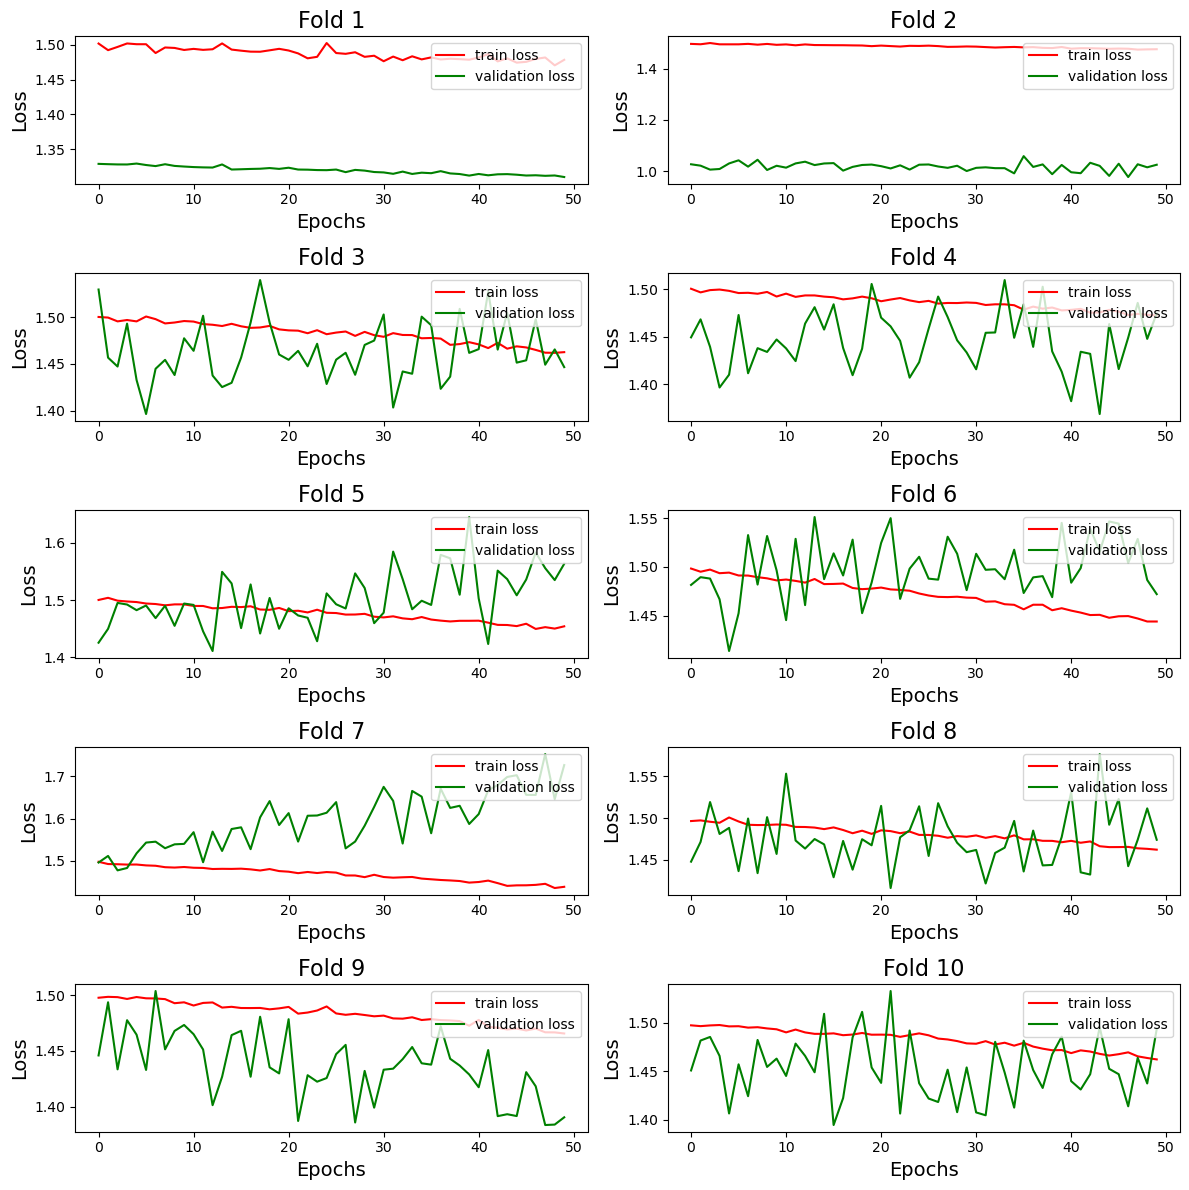

In [36]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 2, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.plot(tL[i],'-r')
    ax.plot(vL[i],'-g')
    ax.legend(['train loss', 'validation loss'],loc ="upper right")
    ax.set_title(f'Fold {i+1}', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)

plt.tight_layout()
plt.show()

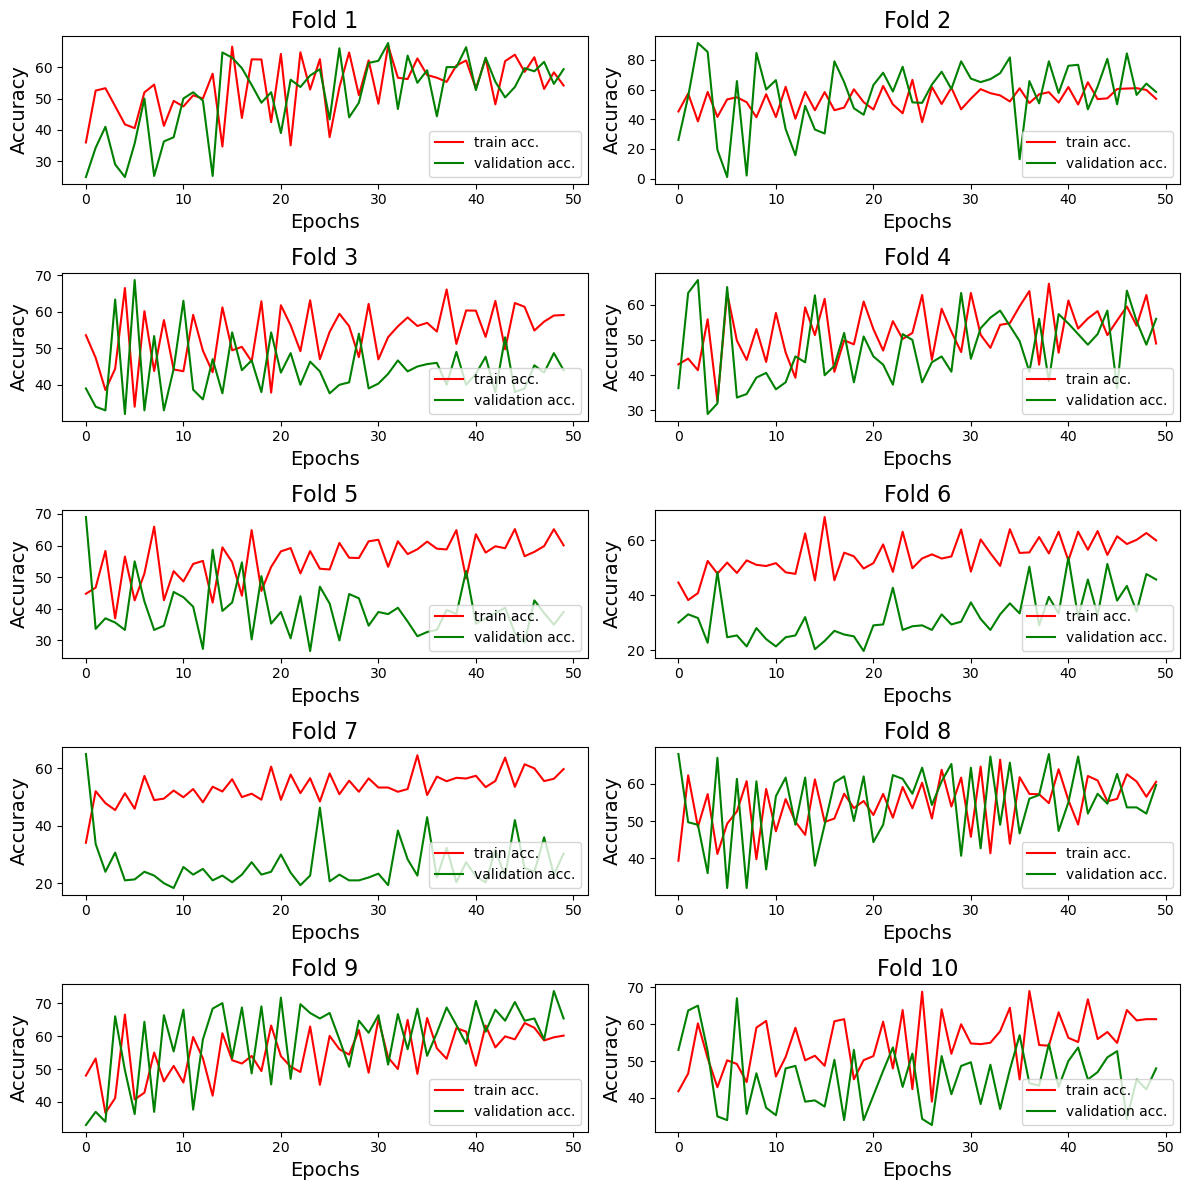

In [37]:
fig, axs = plt.subplots(5,2, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    ax.plot(tAV[i],'-r')
    ax.plot(vAV[i],'-g')
    ax.legend(['train acc.', 'validation acc.'],loc ="lower right")
    ax.set_title(f'Fold {i+1}', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)

plt.tight_layout()
plt.show()

In [38]:
tr = []
pred_gt_tuple = []
for key,value in log_pred_dict.items():
    tr.append(value['trails'])
    pred = torch.cat((value['predicted']),0)
    ground_truth = torch.cat((value['ground truth']),0)
    p = pred.to('cpu').numpy()
    g = ground_truth.to('cpu').numpy()
    print(p.shape)
    print(g.shape)
    pred_gt_tuple.append([p,g])

(300,)
(300,)
(225,)
(225,)
(225,)
(225,)
(225,)
(225,)
(225,)
(225,)
(225,)
(225,)
(225,)
(225,)
(225,)
(225,)
(225,)
(225,)
(225,)
(225,)


In [39]:
pred.shape

torch.Size([225])

In [40]:
log = {'trials': tr,
       'pred_gt': pred_gt_tuple}

In [102]:
scipy.io.savemat('./logs/PLI_s15_s_v.mat',log)